In [ ]:
!pip install numpy librosa soundfile tqdm

In [ ]:
import os
import numpy as np
import librosa
from glob import glob
from tqdm import tqdm

# Config
N_MELS = 3401
N_FFT = 16384
HOP_DURATION = 0.015  # seconds
POWER = 2  # use power=2 per assignment
FMIN = 300.0
FMAX = 3400.0
TARGET_FRAMES = 200  # truncate/pad to 200 frames

# The 5 bands (Hz)
BANDS_HZ = [
    (300, 627),
    (628, 1060),
    (1061, 1633),
    (1634, 2393),
    (2394, 3400)
]

EPS = 1e-10  # small constant to avoid division by zero


In [ ]:
def compute_mel_spectrogram(y, sr, n_mels=N_MELS, n_fft=N_FFT, hop_duration=HOP_DURATION, power=POWER, fmin=FMIN, fmax=FMAX):
    """
    Compute mel-spectrogram (power) with given params. Returns S (n_mels, T) and hop_length used.
    """
    hop_length = int(sr * hop_duration)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=power,
        fmin=fmin,
        fmax=fmax
    )
    return S, hop_length

def fix_num_frames(S, target_frames=TARGET_FRAMES):
    """
    Trim or pad spectrogram S (n_mels x T) to have exactly target_frames columns.
    Padding is done with zeros on the right.
    """
    n_mels, T = S.shape
    if T == target_frames:
        return S
    elif T > target_frames:
        return S[:, :target_frames]
    else:
        pad_width = target_frames - T
        return np.pad(S, ((0, 0), (0, pad_width)), mode='constant', constant_values=0.0)


In [ ]:
def mel_bin_indices_for_bands(n_mels=N_MELS, fmin=FMIN, fmax=FMAX, bands_hz=BANDS_HZ):
    """
    Return list of arrays of mel-bin indices corresponding to each band.
    mel_freqs has length n_mels and is strictly increasing between fmin and fmax.
    """
    mel_freqs = librosa.mel_frequencies(n_mels=n_mels, fmin=fmin, fmax=fmax)
    band_indices = []
    for (lo, hi) in bands_hz:
        # include mel bins whose center freq is inside [lo, hi] inclusive
        idxs = np.where((mel_freqs >= lo - 1e-6) & (mel_freqs <= hi + 1e-6))[0]
        #first freq between lo and hi; from mel freq
        if idxs.size == 0:
            raise ValueError(f"No mel bins found for band {lo}-{hi} Hz. Check n_mels/fmin/fmax.")
        band_indices.append(idxs)
    return band_indices, mel_freqs

# Precompute band indices and mel freqs (reusable)
BAND_INDICES, MEL_FREQS = mel_bin_indices_for_bands()
# quick check
# print(mel_freqs)

# print(BAND_INDICES)
# print(len(BAND_INDICES))
# print(MEL_FREQS)
for i, idxs in enumerate(BAND_INDICES, 1):
    freqs = MEL_FREQS[idxs]
    print(f"Band {i}: {BANDS_HZ[i-1]} Hz -> {len(idxs)} mel bins, freq range in mel bins: {freqs[0]:.2f} - {freqs[-1]:.2f} Hz")


Band 1: (300, 627) Hz -> 590 mel bins, freq range in mel bins: 300.00 - 626.84 Hz
Band 2: (628, 1060) Hz -> 772 mel bins, freq range in mel bins: 628.50 - 1059.81 Hz
Band 3: (1061, 1633) Hz -> 754 mel bins, freq range in mel bins: 1061.02 - 1632.55 Hz
Band 4: (1634, 2393) Hz -> 667 mel bins, freq range in mel bins: 1634.42 - 2392.67 Hz
Band 5: (2394, 3400) Hz -> 614 mel bins, freq range in mel bins: 2394.04 - 3400.00 Hz


In [ ]:
def spectral_features_from_mel_spectrogram(S, band_indices=BAND_INDICES, mel_freqs=MEL_FREQS, eps=EPS):
    """
    S: mel-spectrogram power matrix (n_mels x T), expected T == TARGET_FRAMES (or call fix_num_frames first).
    Returns three arrays:
      SC (5, T), SBW (5, T), SBE (5, T)
    """
    n_bands = len(band_indices)
    n_mels, T = S.shape
    SC = np.zeros((n_bands, T), dtype=np.float32)
    SBW = np.zeros((n_bands, T), dtype=np.float32)
    SBE = np.zeros((n_bands, T), dtype=np.float32)

    for b, idxs in enumerate(band_indices):
        freqs = mel_freqs[idxs]  # shape (M,)
        S_sub = S[idxs, :]       # shape (M, T)
        # band energy per frame
        energy = S_sub.sum(axis=0)  # (T,)
        SBE[b, :] = energy
        # safe denom
        denom = energy.copy()
        denom[denom == 0] = eps

        # spectral centroid (weighted mean freq)
        # freqs[:, None] * S_sub  -> shape (M, T)
        numerator = (freqs[:, None] * S_sub).sum(axis=0)
        SC[b, :] = numerator / denom

        # spectral bandwidth: sqrt( sum((f - SC)^2 * S_sub) / energy )
        # compute squared deviations per mel bin
        # (freqs[:,None] - SC[b,:])**2  broadcast -> shape (M, T)
        diff2 = ((freqs[:, None] - SC[b, :]) ** 2) * S_sub
        var = diff2.sum(axis=0) / denom  # variance per frame
        SBW[b, :] = np.sqrt(np.maximum(var, 0.0))
    return SC, SBW, SBE


In [ ]:
import soundfile as sf

def feature_vector_for_file(wav_path, n_mels=N_MELS, n_fft=N_FFT, hop_duration=HOP_DURATION, power=POWER,
                            fmin=FMIN, fmax=FMAX, target_frames=TARGET_FRAMES, bands_idx=BAND_INDICES, mel_freqs=MEL_FREQS):
    """
    Returns three 1-D feature vectors (SC_vec, SBW_vec, SBE_vec) each of length 5 * target_frames,
    stacking columns of 5 x target_frames (column-major, i.e., Fortran order).
    """
    # load preserving original sr
    y, sr = librosa.load(wav_path, sr=None)
    S, hop_length = compute_mel_spectrogram(y, sr, n_mels=n_mels, n_fft=n_fft, hop_duration=hop_duration, power=power, fmin=fmin, fmax=fmax)
    S_fixed = fix_num_frames(S, target_frames=target_frames)
    SC_mat, SBW_mat, SBE_mat = spectral_features_from_mel_spectrogram(S_fixed, band_indices=bands_idx, mel_freqs=mel_freqs)
    # stack columns (column-major) -> use order='F'
    SC_vec = SC_mat.reshape(-1, order='F')
    SBW_vec = SBW_mat.reshape(-1, order='F')
    SBE_vec = SBE_mat.reshape(-1, order='F')
    return SC_vec, SBW_vec, SBE_vec


In [ ]:
def process_dataset_and_save_features(root_dir, out_dir, pattern="*.wav"):
    """
    root_dir: e.g. 'EmotionSpeech/Train' or 'EmotionSpeech/Test'
    out_dir: where to save per-file features as .npz (contains sc, sbw, sbe arrays)
    Assumes directory structure: root_dir/<emotion_label>/*.wav
    """
    os.makedirs(out_dir, exist_ok=True)
    emotions = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    print("Found emotion classes:", emotions)
    saved = []
    for emotion in emotions:
        folder = os.path.join(root_dir, emotion)
        files = sorted(glob(os.path.join(folder, pattern)))
        for fpath in tqdm(files, desc=f"Processing {emotion}"):
            try:
                sc_vec, sbw_vec, sbe_vec = feature_vector_for_file(fpath)
            except Exception as e:
                print(f"ERROR processing {fpath}: {e}")
                continue
            base = os.path.splitext(os.path.basename(fpath))[0]
            outname = f"{emotion}__{base}.npz"
            outpath = os.path.join(out_dir, outname)
            # Save three arrays in one compressed file
            np.savez_compressed(outpath, sc=sc_vec, sbw=sbw_vec, sbe=sbe_vec, label=emotion, src=fpath)
            saved.append(outpath)
    print(f"Saved {len(saved)} feature files to {out_dir}")
    return saved

# Example usage:
# train_saved = process_dataset_and_save_features("EmotionSpeech/Train", "Features/Train")
# test_saved = process_dataset_and_save_features("EmotionSpeech/Test",  "Features/Test")


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

# '/content/drive/My Drive/Datasets/SpeakerData'

# Example of how to import files from your drive
# Replace 'path/to/your/file.csv' with the actual path to your file
# import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Example single-file usage (change path to an actual wav file in your dataset)
example_file = "/content/drive/My Drive/Datasets/EmotionSpeech/Train/Angry/03-01-05-01-01-01-01.wav"  # change this to a real path
if os.path.exists(example_file):
    sc_vec, sbw_vec, sbe_vec = feature_vector_for_file(example_file)
    print("SC vector shape:", sc_vec.shape)
    print("SBW vector shape:", sbw_vec.shape)
    print("SBE vector shape:", sbe_vec.shape)
    # Save for demo
    np.savez("demo_features_example.npz", sc=sc_vec, sbw=sbw_vec, sbe=sbe_vec)
else:
    print("Example file not found; replace example_file path with an actual file.")


SC vector shape: (1000,)
SBW vector shape: (1000,)
SBE vector shape: (1000,)


/usr/local/lib/python3.12/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


## Experiment with different SVM parameters

### Subtask:
Evaluate the SVM model performance for each feature type (SC, SBW, SBE) using different combinations of C and gamma values for the RBF kernel.

In [ ]:
# Define the base directory for the dataset in Google Drive
dataset_base_dir = "/content/drive/My Drive/Datasets/EmotionSpeech"

# Create a dictionary to store example file paths
example_files = {
    'Train': {},
    'Test': {}
}

# Emotion labels
emotions = ['Angry', 'Calm', 'Happy', 'Sad']

# Find at least one example file for each emotion in Train and Test sets
for split in ['Train', 'Test']:
    for emotion in emotions:
        folder_path = os.path.join(dataset_base_dir, split, emotion)
        # Use glob to find all wav files in the folder
        wav_files = glob(os.path.join(folder_path, "*.wav"))
        if wav_files:
            # Take the first file found as an example (or more if needed)
            example_files[split][emotion] = [wav_files[0]]
        else:
            example_files[split][emotion] = []
            print(f"Warning: No .wav files found for {split}/{emotion}")

# Print the dictionary of example files
print("Selected example files:")
print(example_files)

Selected example files:
{'Train': {'Angry': ['/content/drive/My Drive/Datasets/EmotionSpeech/Train/Angry/03-01-05-01-01-02-03.wav'], 'Calm': ['/content/drive/My Drive/Datasets/EmotionSpeech/Train/Calm/03-01-02-01-02-02-04.wav'], 'Happy': ['/content/drive/My Drive/Datasets/EmotionSpeech/Train/Happy/03-01-03-01-02-01-01.wav'], 'Sad': ['/content/drive/My Drive/Datasets/EmotionSpeech/Train/Sad/03-01-04-02-01-01-01.wav']}, 'Test': {'Angry': ['/content/drive/My Drive/Datasets/EmotionSpeech/Test/Angry/03-01-05-01-01-01-06.wav'], 'Calm': ['/content/drive/My Drive/Datasets/EmotionSpeech/Test/Calm/03-01-02-02-01-01-07.wav'], 'Happy': ['/content/drive/My Drive/Datasets/EmotionSpeech/Test/Happy/03-01-03-01-01-02-07.wav'], 'Sad': ['/content/drive/My Drive/Datasets/EmotionSpeech/Test/Sad/03-01-04-01-02-01-06.wav']}}


**Reasoning**:
Iterate through a predefined set of C and gamma values, train an SVM for each combination and feature type, and store the results.

In [ ]:
# Call compute_mel_spectrogram for the example file
example_file = "/content/drive/My Drive/Datasets/EmotionSpeech/Train/Angry/03-01-05-01-01-01-01.wav"  # change this to a real path

if os.path.exists(example_file):
    y, sr = librosa.load(example_file, sr=None)
    S, hop_length = compute_mel_spectrogram(y, sr)
    print("Shape of S:", S.shape)
    print("Hop length:", hop_length)
else:
    print("Example file not found; replace example_file path with an actual file.")

Shape of S: (3401, 259)
Hop length: 720


# Task 1
Implement a speech emotion recognition model using an SVM (with C=10.0 and RBF kernel) to classify emotions from the "EmotionSpeech" dataset. Evaluate the model using Spectral Centroid (SC), Spectral Bandwidth (SBW), and Spectral Band Energy (SBE) features. Determine the best performing feature vector based on recognition accuracy and confusion matrices. Use the provided dataset structure with 'Train' and 'Test' subfolders containing audio data for 'calm', 'happy', 'sad', and 'angry' emotions from 8 actors. The dataset is located at "EmotionSpeech".

## Load and process data

### Subtask:
Use the existing `process_dataset_and_save_features` function to process the training and testing datasets and save the extracted SC, SBW, and SBE features along with their labels.


**Reasoning**:
Define the input and output directories and call the `process_dataset_and_save_features` function for both training and testing data.



In [ ]:
# Example: update to your actual Google Drive path if needed
dataset_base_dir = "/content/drive/My Drive/Datasets/EmotionSpeech"
features_output_dir = "/content/drive/My Drive/Features"

# Training
train_root_dir = os.path.join(dataset_base_dir, "Train")
train_features_dir = os.path.join(features_output_dir, "Train")
train_saved_files = process_dataset_and_save_features(train_root_dir, train_features_dir)
print("Number of training feature files saved:", len(train_saved_files))

# Testing
test_root_dir = os.path.join(dataset_base_dir, "Test")
test_features_dir = os.path.join(features_output_dir, "Test")
test_saved_files = process_dataset_and_save_features(test_root_dir, test_features_dir)
print("Number of testing feature files saved:", len(test_saved_files))


Found emotion classes: ['Angry', 'Calm', 'Happy', 'Sad']


Processing Sad: 100%|██████████| 32/32 [00:22<00:00,  1.45it/s]


Saved 128 feature files to /content/drive/My Drive/Features/Train
Number of training feature files saved: 128
Found emotion classes: ['Angry', 'Calm', 'Happy', 'Sad']


Processing Sad: 100%|██████████| 32/32 [00:22<00:00,  1.43it/s]

Saved 128 feature files to /content/drive/My Drive/Features/Test
Number of testing feature files saved: 128


In [ ]:
# # Define the base directory for the dataset in Google Drive
# dataset_base_dir = "/content/drive/My Drive/Datasets/EmotionSpeech"

# # Define the output directory for saving extracted features
# features_output_dir = "/content/drive/My Drive/Features"

# # Process the training data
# train_root_dir = os.path.join(dataset_base_dir, "Train")
# train_features_dir = os.path.join(features_output_dir, "Train")
# train_saved_files = process_dataset_and_save_features(train_root_dir, train_features_dir)

# # Process the testing data
# test_root_dir = os.path.join(dataset_base_dir, "Test")
# test_features_dir = os.path.join(features_output_dir, "Test")
# test_saved_files = process_dataset_and_save_features(test_root_dir, test_features_dir)

# print(f"Number of training feature files saved: {len(train_saved_files)}")
# print(f"Number of testing feature files saved: {len(test_saved_files)}")

## Load features and labels

### Subtask:
Load the saved `.npz` files for the training and testing sets into NumPy arrays, separating the features (SC, SBW, SBE) and their corresponding emotion labels.


**Reasoning**:
Load the saved .npz files into NumPy arrays for training and testing, separating features and labels.



In [ ]:
# Define the directories where the training and testing feature files (.npz) were saved.
train_features_dir = "/content/drive/My Drive/Features/Train"
test_features_dir = "/content/drive/My Drive/Features/Test"

# Initialize empty lists to store the loaded features and labels.
train_sc_list = []
train_sbw_list = []
train_sbe_list = []
train_labels_list = []

test_sc_list = []
test_sbw_list = []
test_sbe_list = []
test_labels_list = []

# Iterate through the files in the training feature directory and load the data.
train_feature_files = glob(os.path.join(train_features_dir, "*.npz"))
for fpath in tqdm(train_feature_files, desc="Loading training features"):
    data = np.load(fpath)
    train_sc_list.append(data['sc'])
    train_sbw_list.append(data['sbw'])
    train_sbe_list.append(data['sbe'])
    train_labels_list.append(str(data['label'])) # Ensure label is a string

# Iterate through the files in the testing feature directory and load the data.
test_feature_files = glob(os.path.join(test_features_dir, "*.npz"))
for fpath in tqdm(test_feature_files, desc="Loading testing features"):
    data = np.load(fpath)
    test_sc_list.append(data['sc'])
    test_sbw_list.append(data['sbw'])
    test_sbe_list.append(data['sbe'])
    test_labels_list.append(str(data['label'])) # Ensure label is a string

# Convert the lists to NumPy arrays.
train_sc_features = np.array(train_sc_list)
train_sbw_features = np.array(train_sbw_list)
train_sbe_features = np.array(train_sbe_list)
train_labels = np.array(train_labels_list)

test_sc_features = np.array(test_sc_list)
test_sbw_features = np.array(test_sbw_list)
test_sbe_features = np.array(test_sbe_list)
test_labels = np.array(test_labels_list)

print("Train SC features shape:", train_sc_features.shape)
print("Train SBW features shape:", train_sbw_features.shape)
print("Train SBE features shape:", train_sbe_features.shape)
print("Train labels shape:", train_labels.shape)

print("Test SC features shape:", test_sc_features.shape)
print("Test SBW features shape:", test_sbw_features.shape)
print("Test SBE features shape:", test_sbe_features.shape)
print("Test labels shape:", test_labels.shape)

Loading testing features: 100%|██████████| 128/128 [00:00<00:00, 241.55it/s]

Train SC features shape: (128, 1000)
Train SBW features shape: (128, 1000)
Train SBE features shape: (128, 1000)
Train labels shape: (128,)
Test SC features shape: (128, 1000)
Test SBW features shape: (128, 1000)
Test SBE features shape: (128, 1000)
Test labels shape: (128,)


## Prepare data for svm

### Subtask:
Reshape and organize the loaded feature vectors (SC, SBW, SBE) for training and testing the SVM model. Ensure the data is in a suitable format for scikit-learn's SVM.


**Reasoning**:
Standardize the training and testing feature sets using StandardScaler.



In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler_sc = StandardScaler()
scaler_sbw = StandardScaler()
scaler_sbe = StandardScaler()

# Fit on training data and transform both training and testing data for each feature set
train_sc_scaled = scaler_sc.fit_transform(train_sc_features)
test_sc_scaled = scaler_sc.transform(test_sc_features)

train_sbw_scaled = scaler_sbw.fit_transform(train_sbw_features)
test_sbw_scaled = scaler_sbw.transform(test_sbw_features)

train_sbe_scaled = scaler_sbe.fit_transform(train_sbe_features)
test_sbe_scaled = scaler_sbe.transform(test_sbe_features)

print("Scaled Train SC features shape:", train_sc_scaled.shape)
print("Scaled Test SC features shape:", test_sc_scaled.shape)
print("Scaled Train SBW features shape:", train_sbw_scaled.shape)
print("Scaled Test SBW features shape:", test_sbw_scaled.shape)
print("Scaled Train SBE features shape:", train_sbe_scaled.shape)
print("Scaled Test SBE features shape:", test_sbe_scaled.shape)

Scaled Train SC features shape: (128, 1000)
Scaled Test SC features shape: (128, 1000)
Scaled Train SBW features shape: (128, 1000)
Scaled Test SBW features shape: (128, 1000)
Scaled Train SBE features shape: (128, 1000)
Scaled Test SBE features shape: (128, 1000)


## Train and evaluate svm for each feature type

### Subtask:
For each feature type (SC, SBW, SBE): train an SVM model, evaluate its performance, calculate and print the accuracy, and display the confusion matrix.


--- Visualizing Mel-Spectrograms for Train set ---


/usr/local/lib/python3.12/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


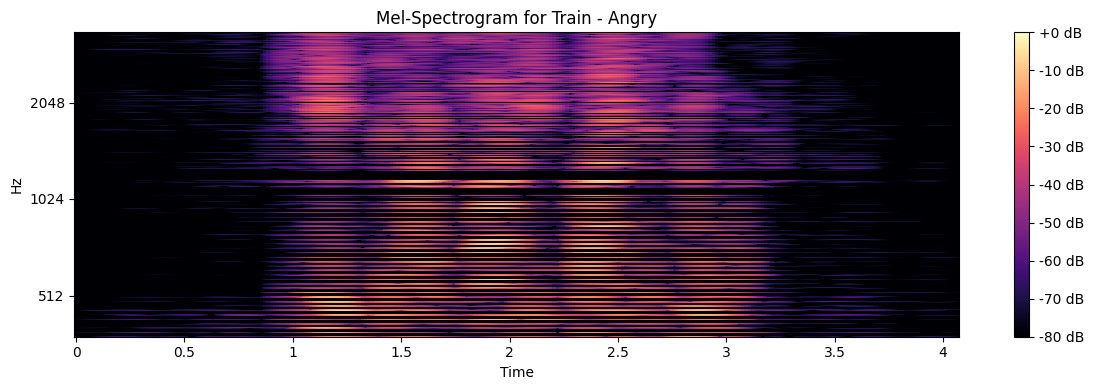

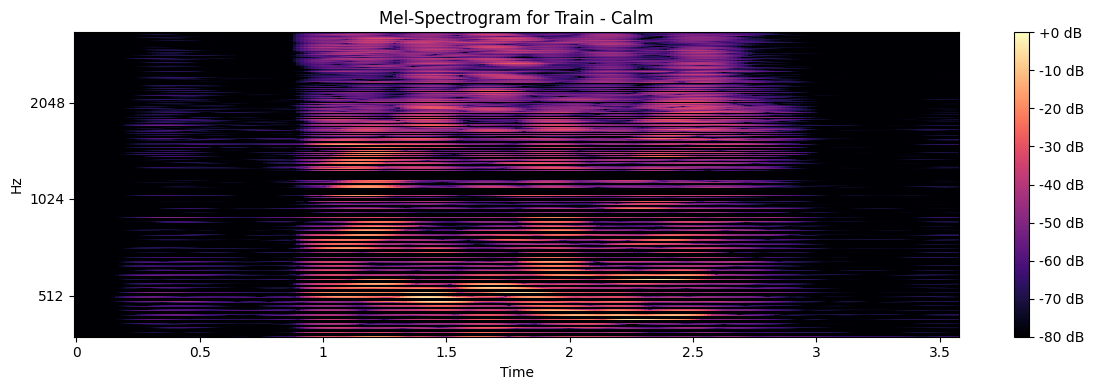

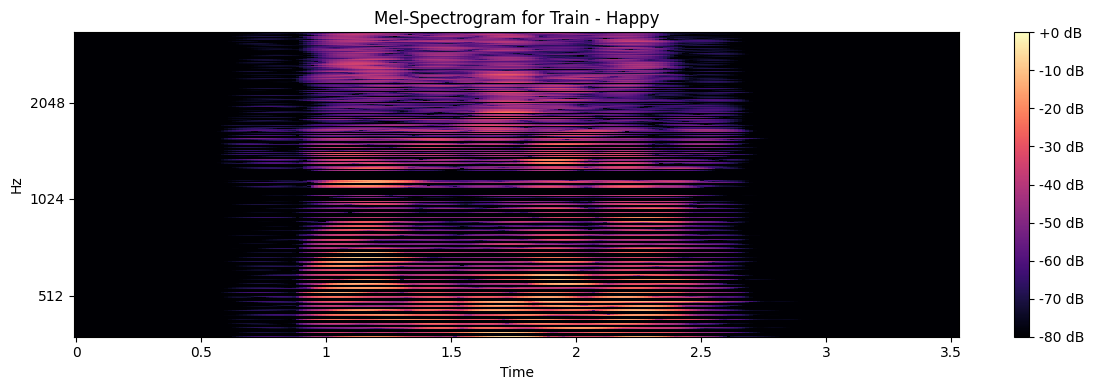

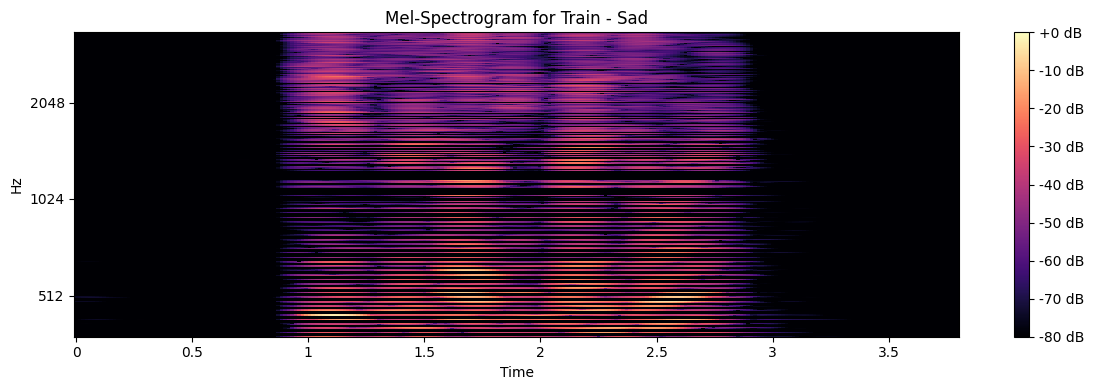

--- Visualizing Mel-Spectrograms for Test set ---


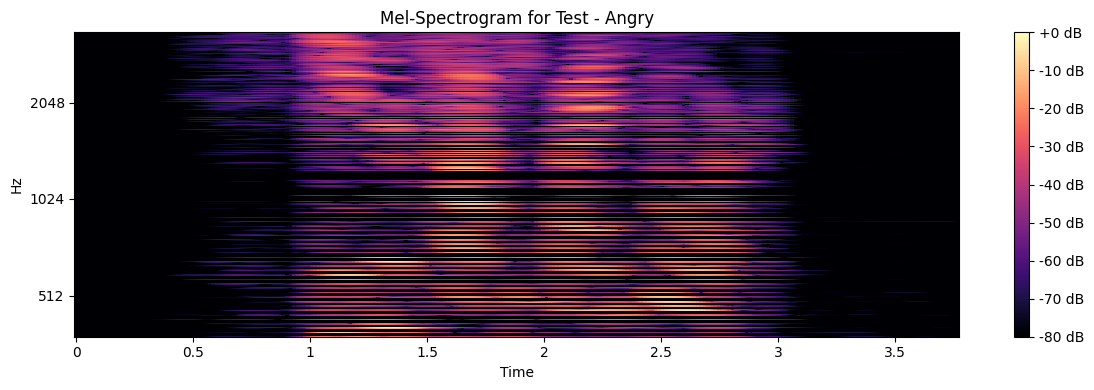

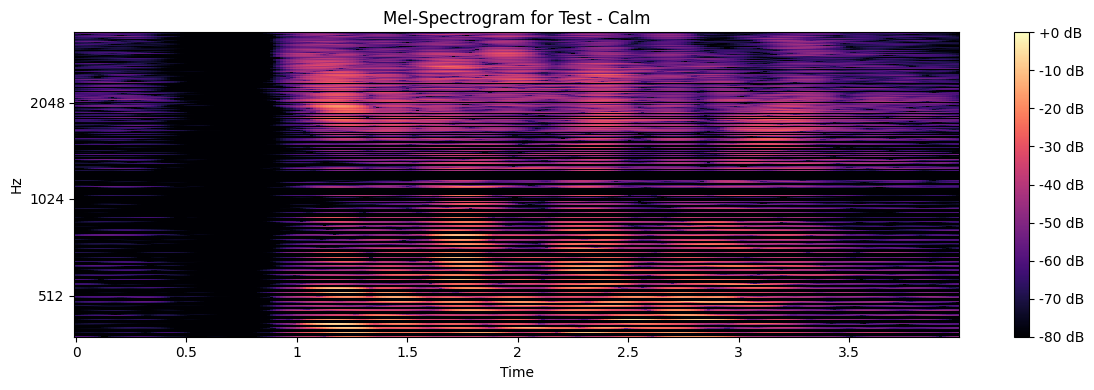

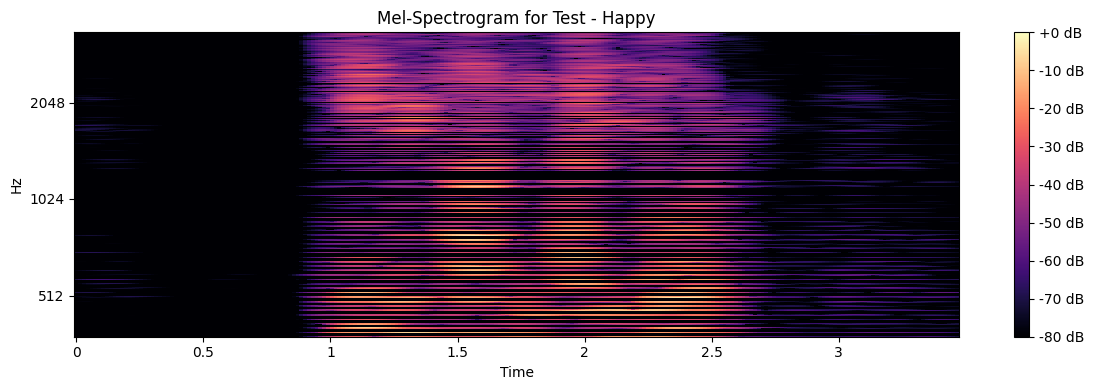

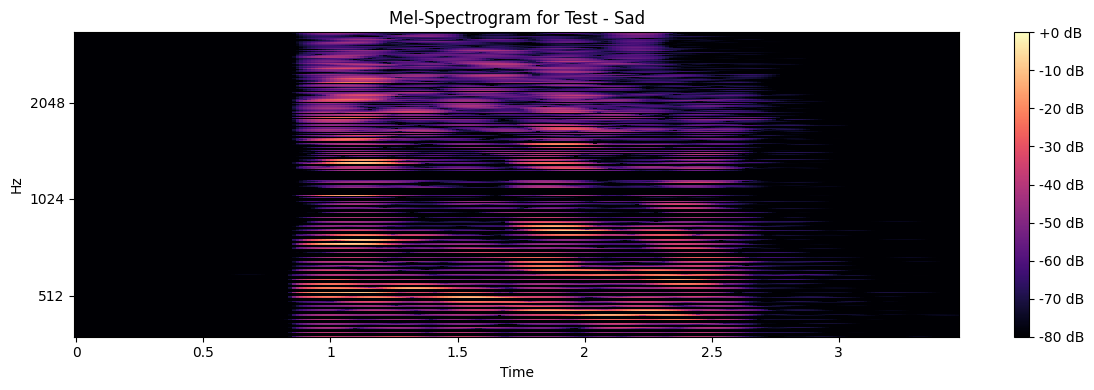

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Iterate through the example files and visualize the mel-spectrogram for each
for split, emotions_dict in example_files.items():
    print(f"--- Visualizing Mel-Spectrograms for {split} set ---")
    for emotion, file_list in emotions_dict.items():
        if file_list:
            file_path = file_list[0] # Use the first file in the list

            try:
                # Load the audio file
                y, sr = librosa.load(file_path, sr=None)

                # Compute the mel-spectrogram
                # Using the previously defined function compute_mel_spectrogram
                S, hop_length = compute_mel_spectrogram(y, sr)

                # Convert power spectrogram to dB scale for visualization
                S_db = librosa.power_to_db(S, ref=np.max)

                # Visualize the mel-spectrogram
                plt.figure(figsize=(12, 4))
                librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', fmin=FMIN, fmax=FMAX)
                plt.colorbar(format='%+2.0f dB')
                plt.title(f'Mel-Spectrogram for {split} - {emotion}')
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        else:
            print(f"No example file available for {split}/{emotion}")


#Task 2

**Reasoning**:
Train an SVM model for each feature type (SC, SBW, SBE), evaluate its performance using accuracy and confusion matrix, and print the results.



--- Training and evaluating SVM with SC features ---
Accuracy for SC: 0.5469
Confusion Matrix for SC:


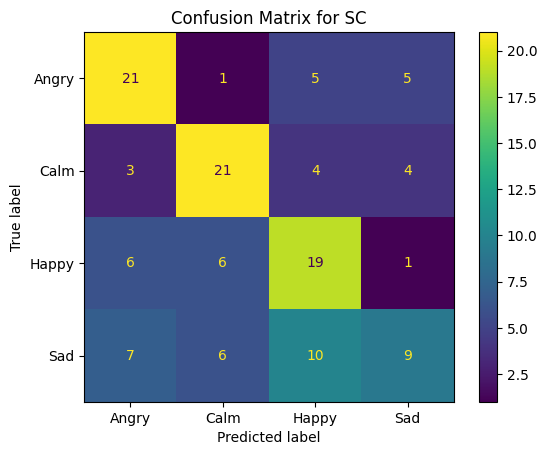

--- Training and evaluating SVM with SBW features ---
Accuracy for SBW: 0.5000
Confusion Matrix for SBW:


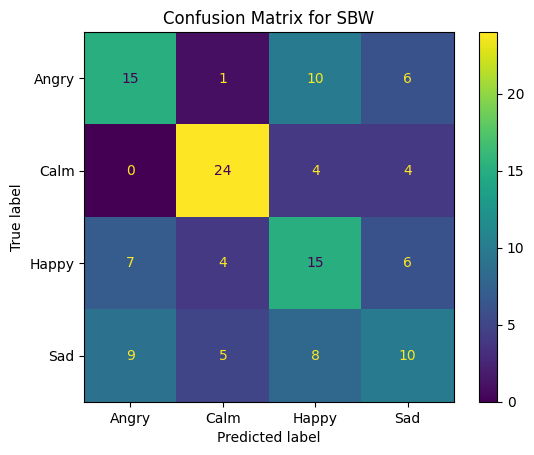

--- Training and evaluating SVM with SBE features ---
Accuracy for SBE: 0.4375
Confusion Matrix for SBE:


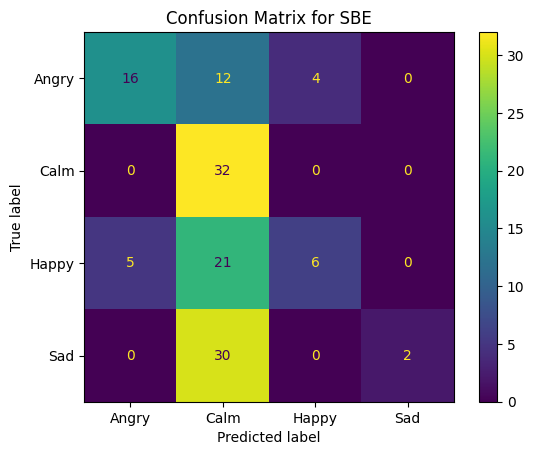

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd # Import pandas for displaying confusion matrix nicely
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Prepare data in a dictionary for easy iteration
feature_data = {
    'SC': (train_sc_scaled, test_sc_scaled),
    'SBW': (train_sbw_scaled, test_sbw_scaled),
    'SBE': (train_sbe_scaled, test_sbe_scaled)
}

# Labels are the same for all features
train_labels_data = train_labels
test_labels_data = test_labels

results = {}

for feature_name, (X_train, X_test) in feature_data.items():
    print(f"--- Training and evaluating SVM with {feature_name} features ---")

    # Instantiate SVM model
    svm_model = SVC(C=10.0, kernel='rbf')

    # Train the model
    svm_model.fit(X_train, train_labels_data)

    # Make predictions on the test data
    y_pred = svm_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels_data, y_pred)
    print(f"Accuracy for {feature_name}: {accuracy:.4f}")

    # Calculate confusion matrix
    cm = confusion_matrix(test_labels_data, y_pred, labels=np.unique(train_labels_data))

    # Display confusion matrix as an image
    print(f"Confusion Matrix for {feature_name}:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(train_labels_data))
    disp.plot()
    plt.title(f'Confusion Matrix for {feature_name}')
    plt.show()

    # Store results (keeping the pandas DataFrame for the results summary later)
    cm_df = pd.DataFrame(cm, index=np.unique(train_labels_data), columns=np.unique(train_labels_data))
    results[feature_name] = {'accuracy': accuracy, 'confusion_matrix': cm_df}

## Determine the best feature vector

### Subtask:
Compare the recognition accuracies and confusion matrices obtained for each feature type (SC, SBW, SBE) to determine which feature vector performs best for this task.


**Reasoning**:
Review the results dictionary to identify the best performing feature based on accuracy and then briefly examine the confusion matrix for that feature.



##Diiferent values of C and RBF Kernel

--- Experimenting with SC features ---
  Training with C=0.1, gamma=scale
  Accuracy: 0.5156
  Training with C=0.1, gamma=auto
  Accuracy: 0.5156
  Training with C=0.1, gamma=0.01
  Accuracy: 0.2500
  Training with C=0.1, gamma=0.1
  Accuracy: 0.2500
  Training with C=0.1, gamma=1.0
  Accuracy: 0.2969
  Training with C=1.0, gamma=scale
  Accuracy: 0.5469
  Training with C=1.0, gamma=auto
  Accuracy: 0.5469
  Training with C=1.0, gamma=0.01
  Accuracy: 0.2812
  Training with C=1.0, gamma=0.1
  Accuracy: 0.2500
  Training with C=1.0, gamma=1.0
  Accuracy: 0.2969
  Training with C=10.0, gamma=scale
  Accuracy: 0.5469
  Training with C=10.0, gamma=auto
  Accuracy: 0.5469
  Training with C=10.0, gamma=0.01
  Accuracy: 0.2891
  Training with C=10.0, gamma=0.1
  Accuracy: 0.2500
  Training with C=10.0, gamma=1.0
  Accuracy: 0.2969
  Training with C=100.0, gamma=scale
  Accuracy: 0.5469
  Training with C=100.0, gamma=auto
  Accuracy: 0.5469
  Training with C=100.0, gamma=0.01
  Accuracy: 0.289

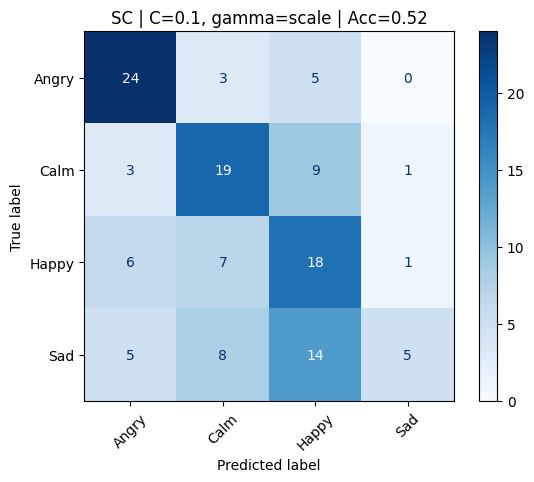

  C=0.1, gamma=scale: Accuracy = 0.5156


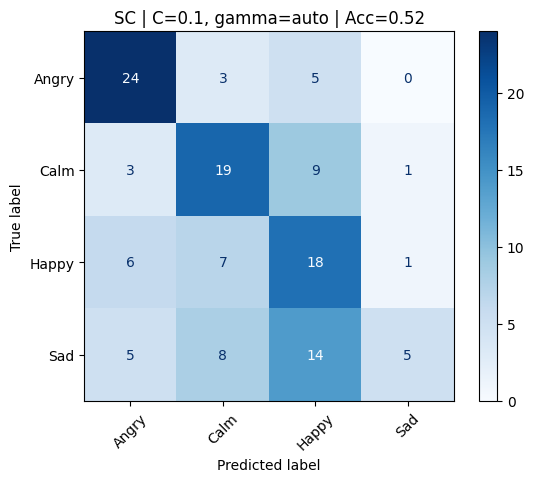

  C=0.1, gamma=auto: Accuracy = 0.5156


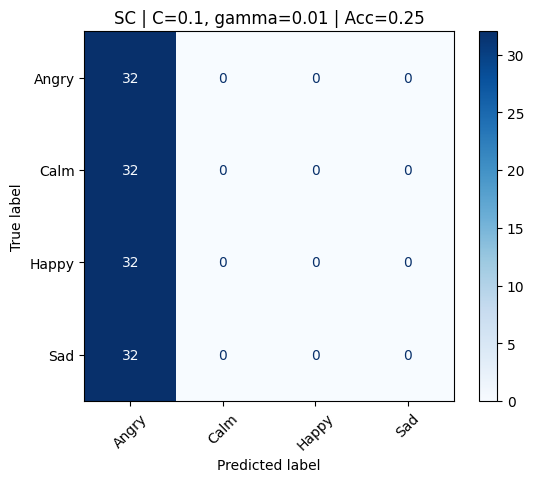

  C=0.1, gamma=0.01: Accuracy = 0.2500


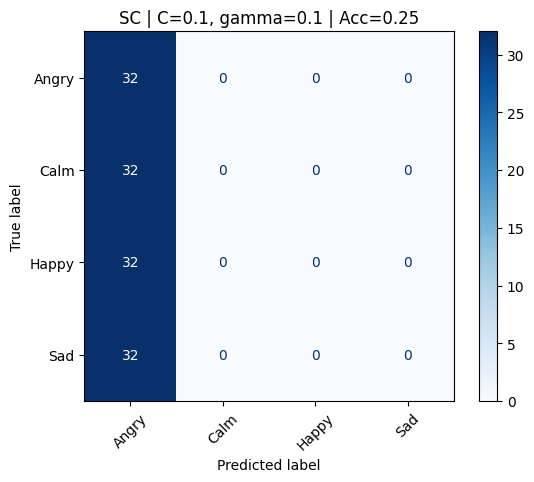

  C=0.1, gamma=0.1: Accuracy = 0.2500


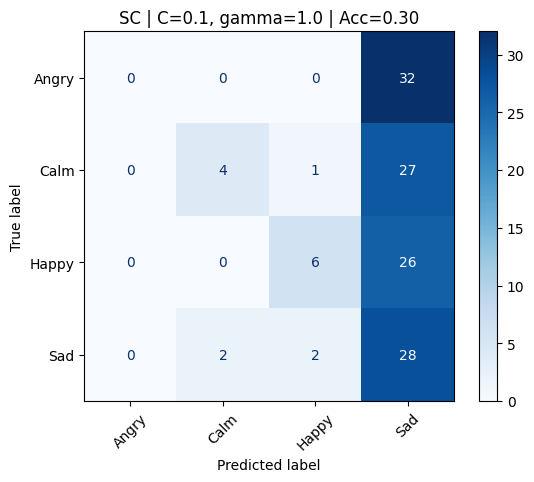

  C=0.1, gamma=1.0: Accuracy = 0.2969


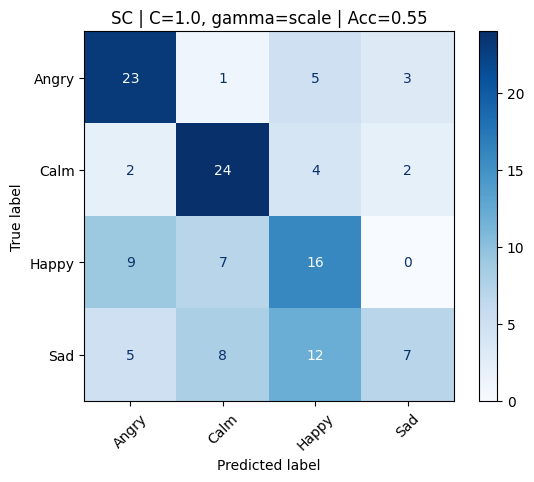

  C=1.0, gamma=scale: Accuracy = 0.5469


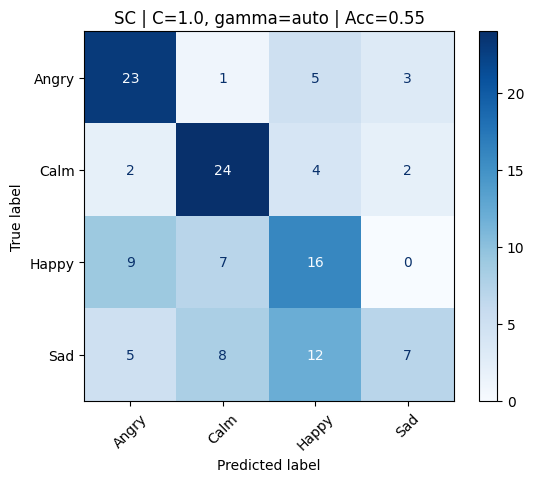

  C=1.0, gamma=auto: Accuracy = 0.5469


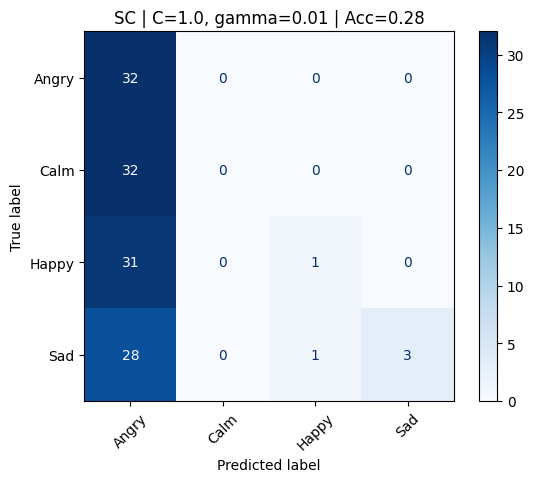

  C=1.0, gamma=0.01: Accuracy = 0.2812


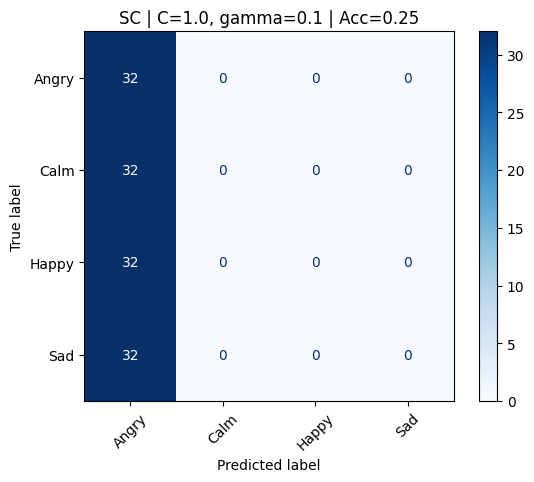

  C=1.0, gamma=0.1: Accuracy = 0.2500


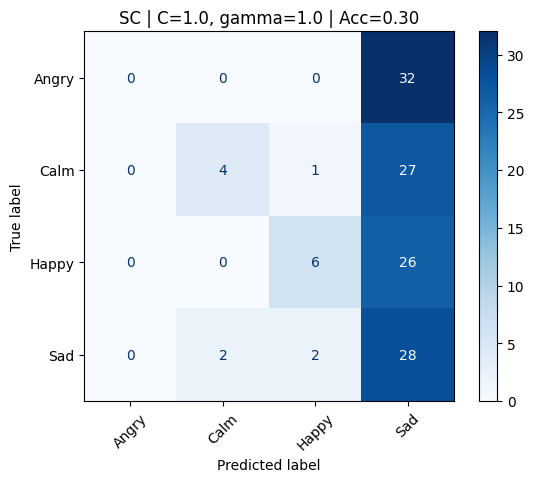

  C=1.0, gamma=1.0: Accuracy = 0.2969


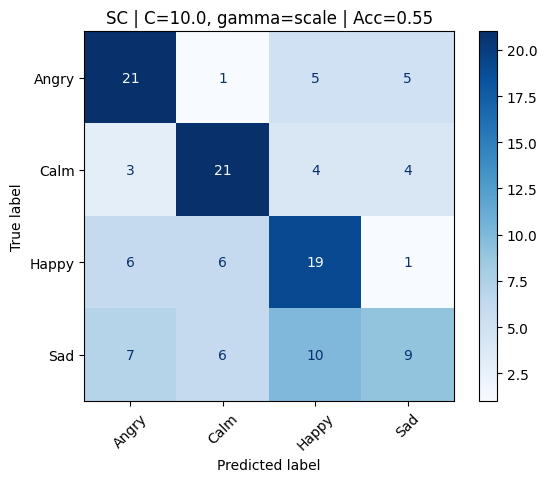

  C=10.0, gamma=scale: Accuracy = 0.5469


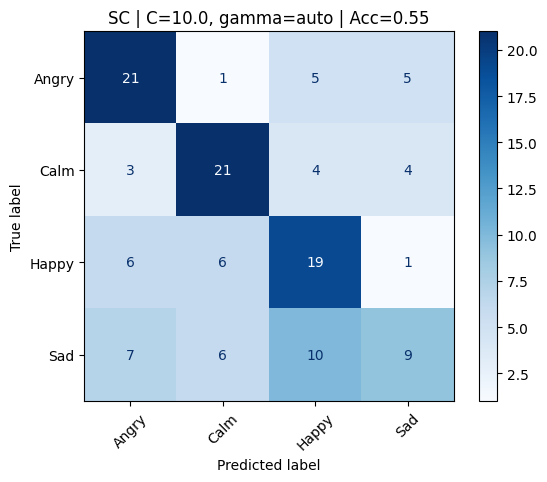

  C=10.0, gamma=auto: Accuracy = 0.5469


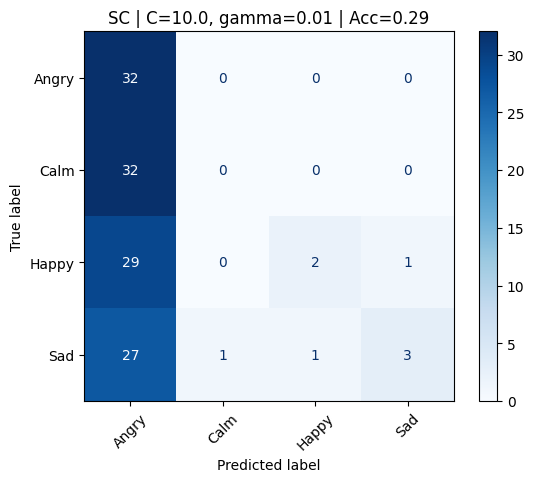

  C=10.0, gamma=0.01: Accuracy = 0.2891


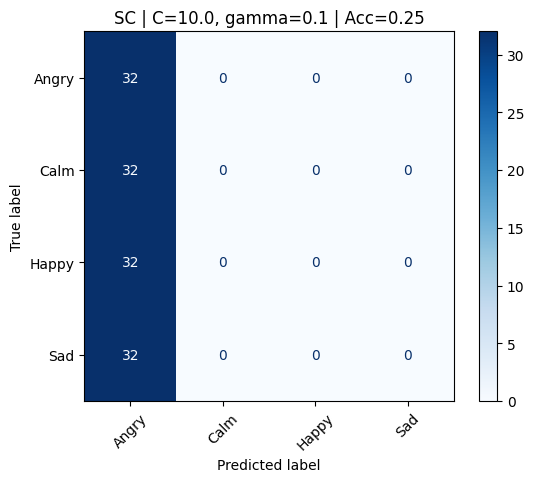

  C=10.0, gamma=0.1: Accuracy = 0.2500


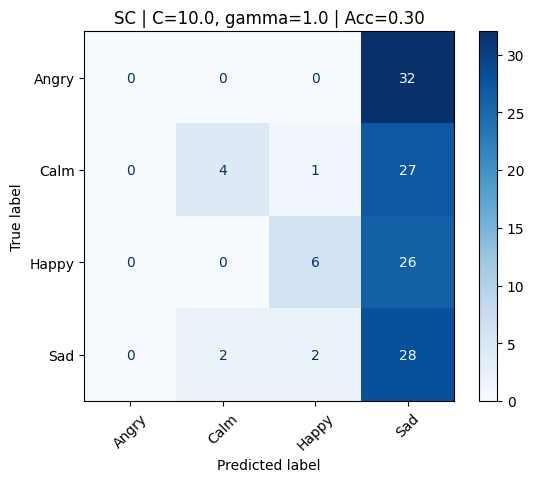

  C=10.0, gamma=1.0: Accuracy = 0.2969


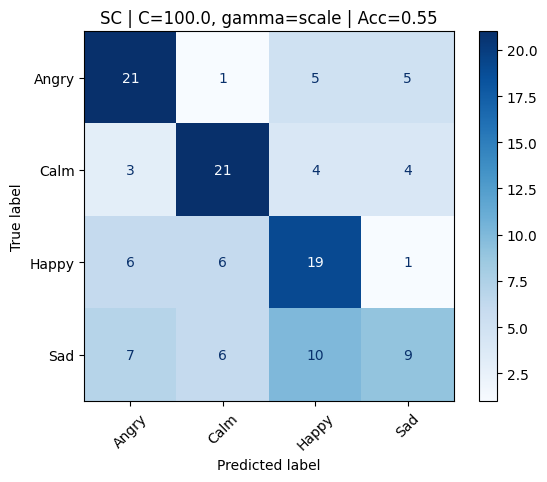

  C=100.0, gamma=scale: Accuracy = 0.5469


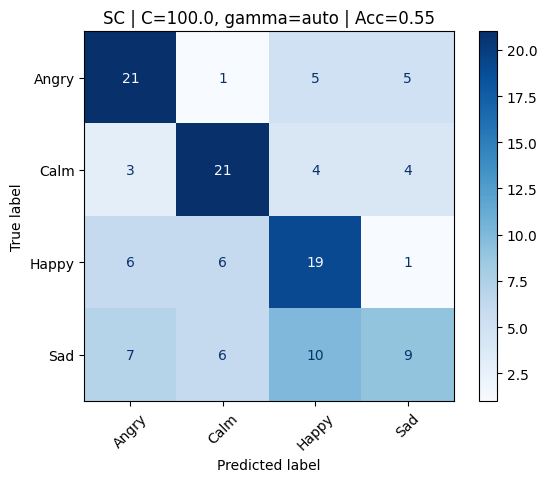

  C=100.0, gamma=auto: Accuracy = 0.5469


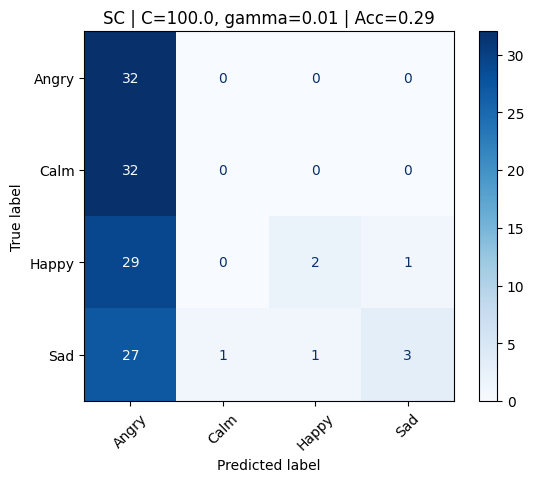

  C=100.0, gamma=0.01: Accuracy = 0.2891


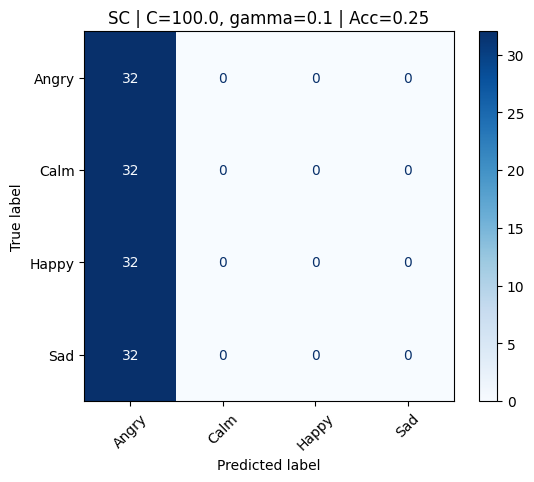

  C=100.0, gamma=0.1: Accuracy = 0.2500


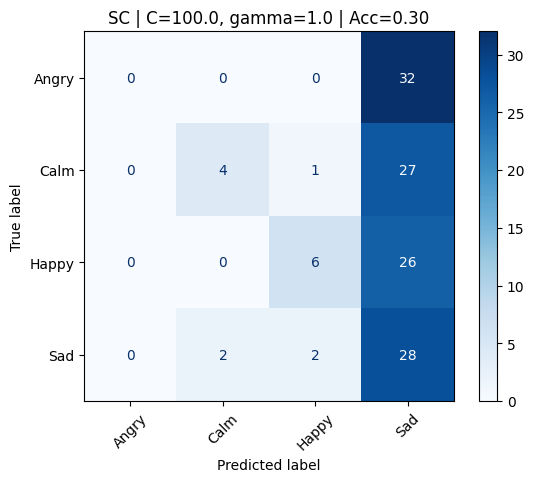

  C=100.0, gamma=1.0: Accuracy = 0.2969
  Best parameters for SC: C=1.0, gamma=scale (Accuracy: 0.5469)
--------------------
Results for SBW features:


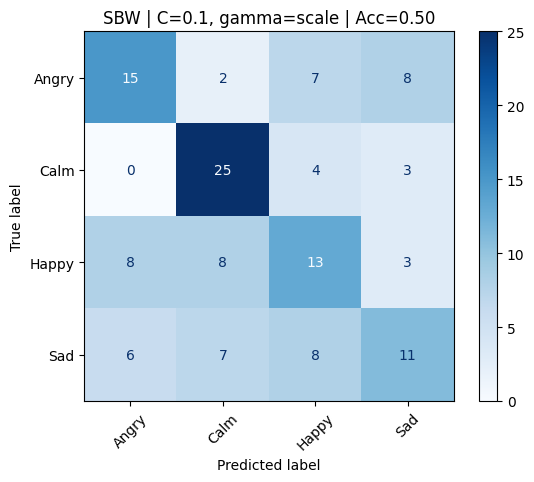

  C=0.1, gamma=scale: Accuracy = 0.5000


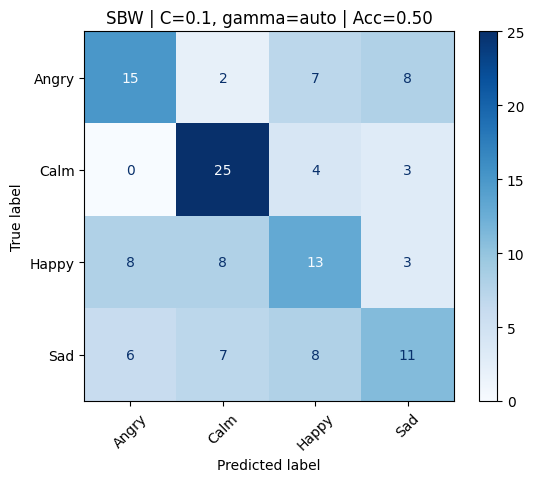

  C=0.1, gamma=auto: Accuracy = 0.5000


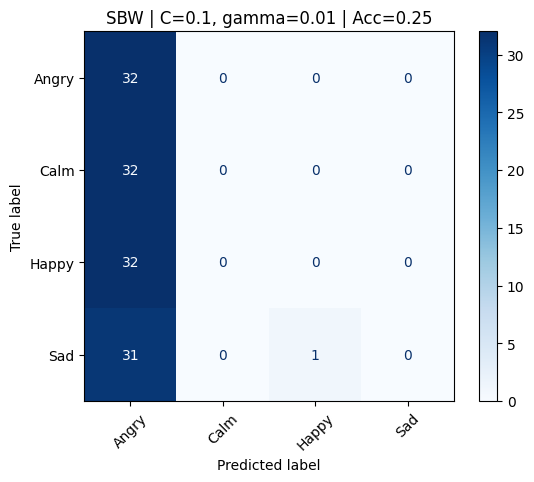

  C=0.1, gamma=0.01: Accuracy = 0.2500


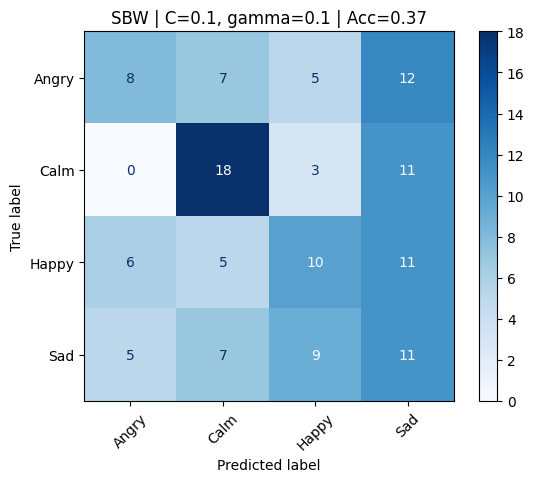

  C=0.1, gamma=0.1: Accuracy = 0.3672


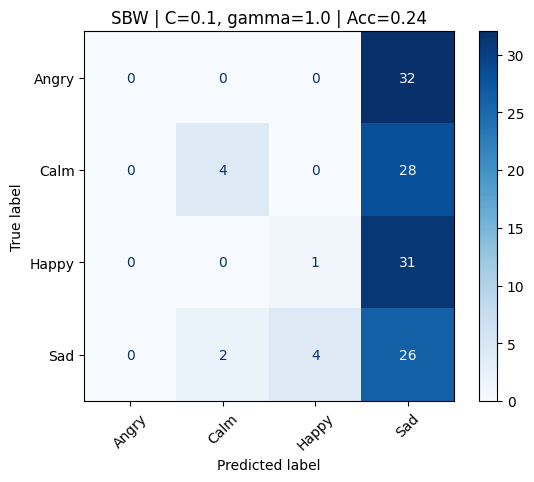

  C=0.1, gamma=1.0: Accuracy = 0.2422


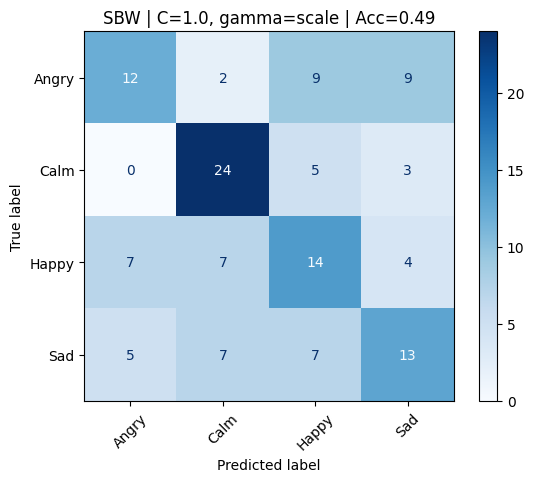

  C=1.0, gamma=scale: Accuracy = 0.4922


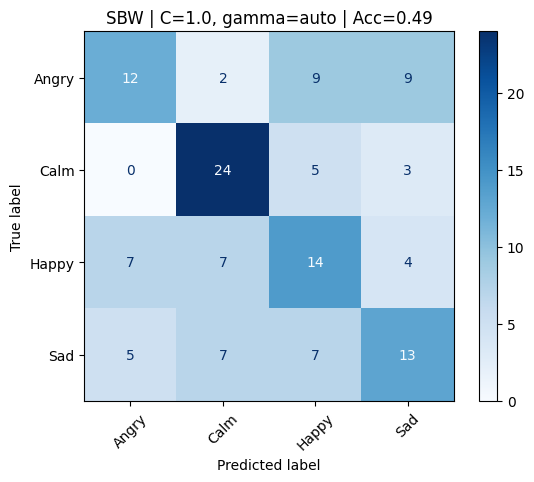

  C=1.0, gamma=auto: Accuracy = 0.4922


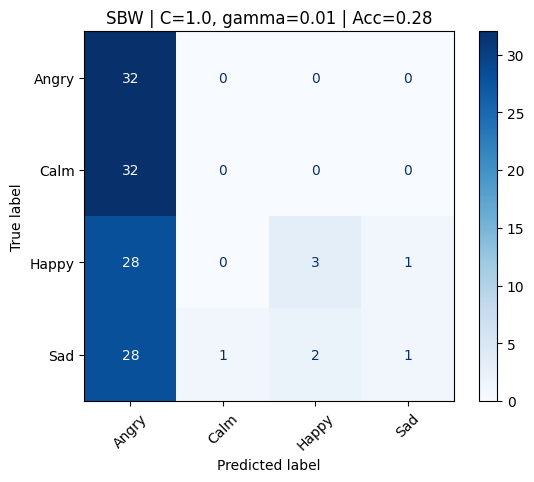

  C=1.0, gamma=0.01: Accuracy = 0.2812


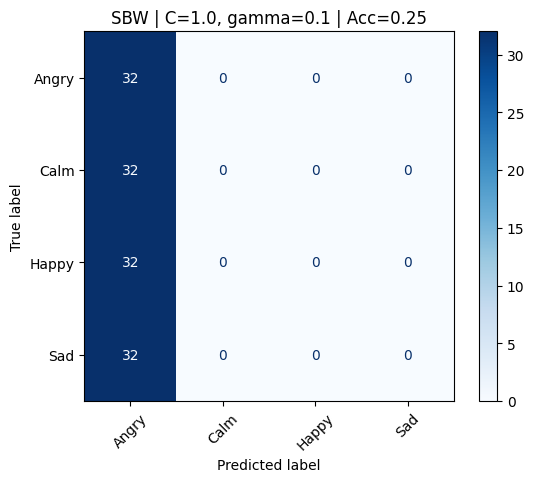

  C=1.0, gamma=0.1: Accuracy = 0.2500


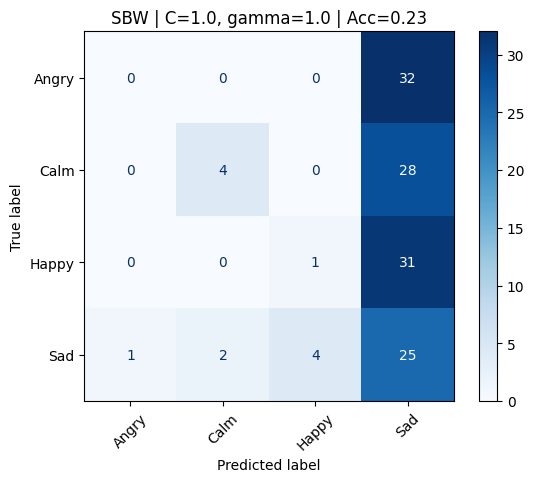

  C=1.0, gamma=1.0: Accuracy = 0.2344


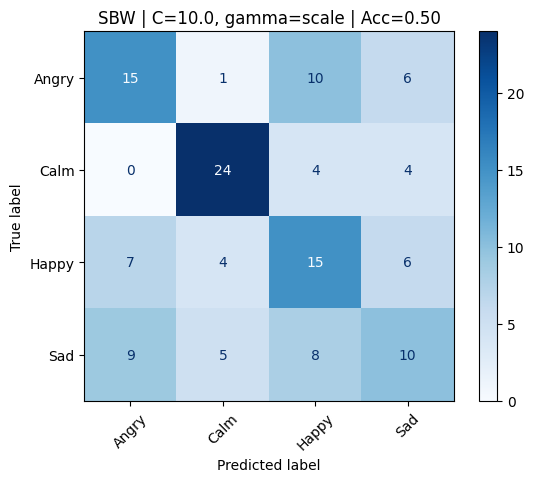

  C=10.0, gamma=scale: Accuracy = 0.5000


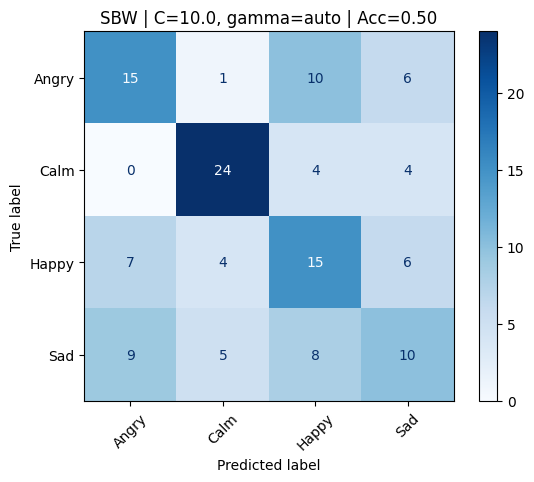

  C=10.0, gamma=auto: Accuracy = 0.5000


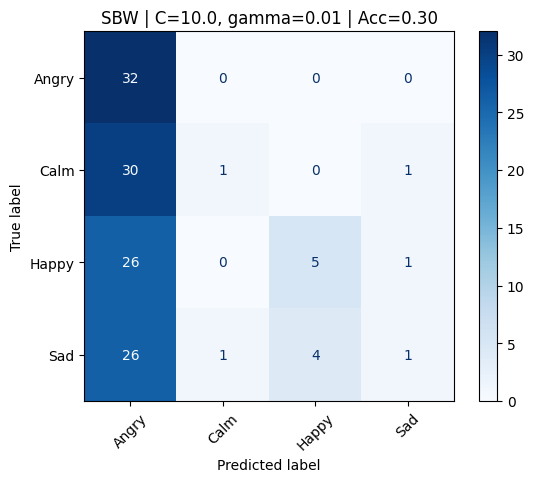

  C=10.0, gamma=0.01: Accuracy = 0.3047


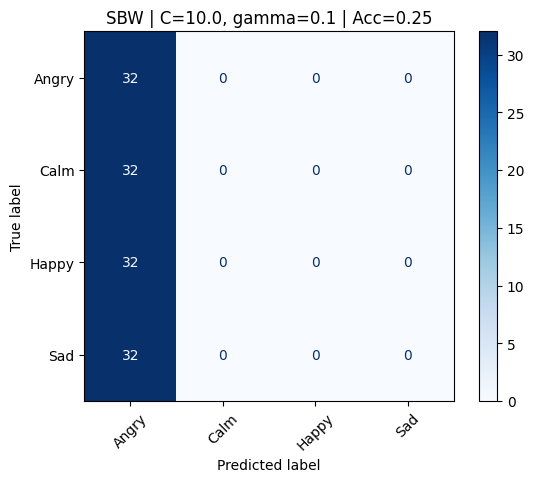

  C=10.0, gamma=0.1: Accuracy = 0.2500


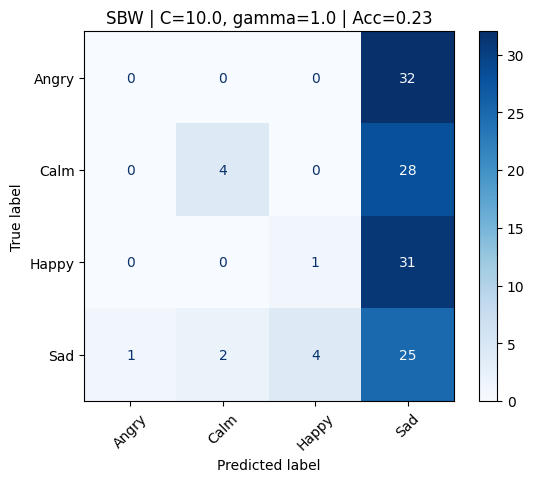

  C=10.0, gamma=1.0: Accuracy = 0.2344


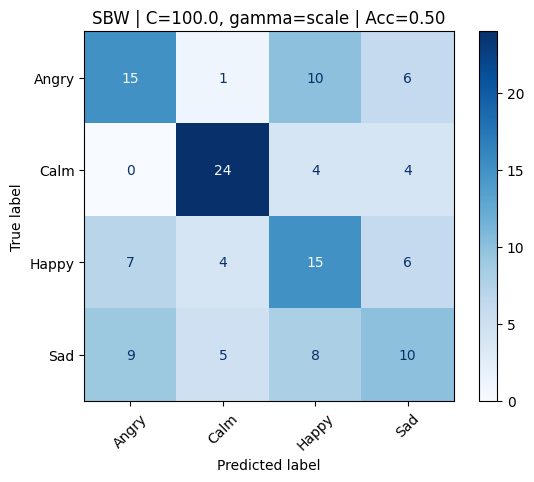

  C=100.0, gamma=scale: Accuracy = 0.5000


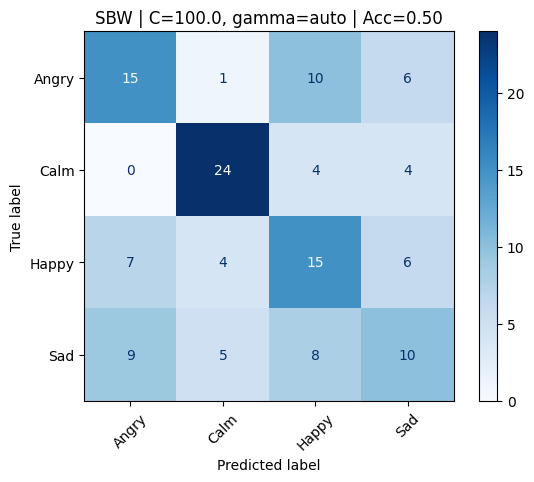

  C=100.0, gamma=auto: Accuracy = 0.5000


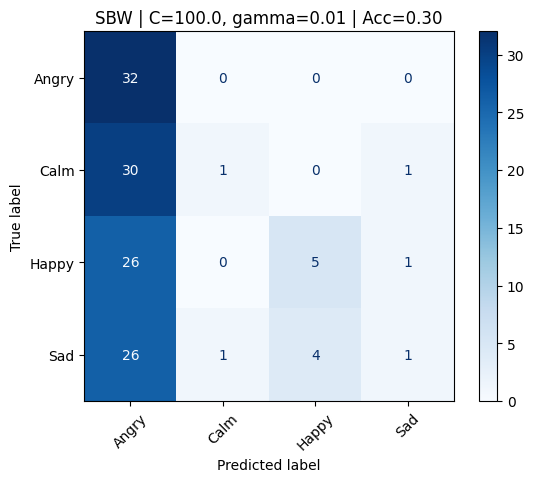

  C=100.0, gamma=0.01: Accuracy = 0.3047


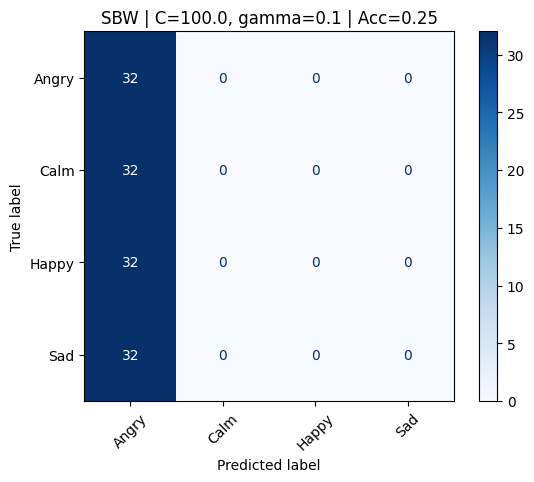

  C=100.0, gamma=0.1: Accuracy = 0.2500


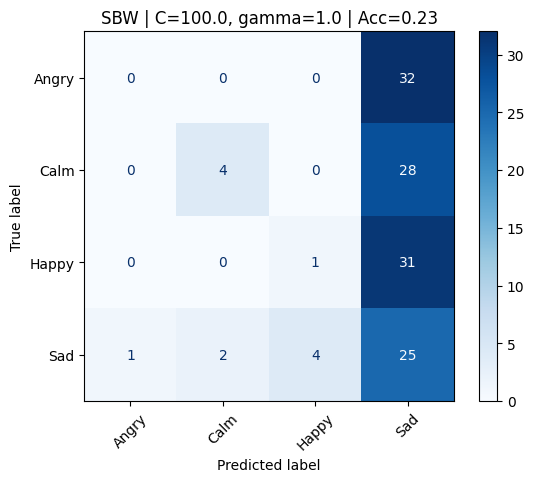

  C=100.0, gamma=1.0: Accuracy = 0.2344
  Best parameters for SBW: C=0.1, gamma=scale (Accuracy: 0.5000)
--------------------
Results for SBE features:


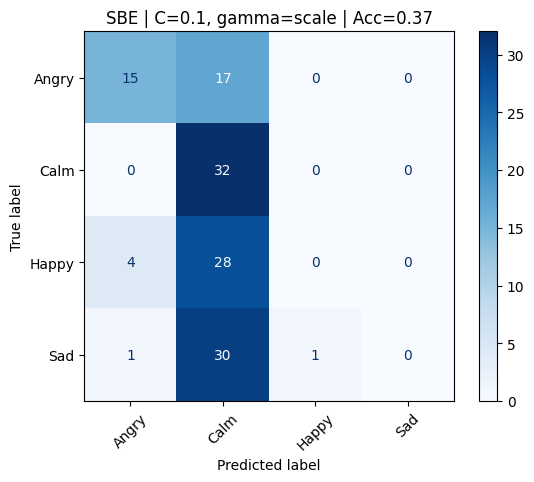

  C=0.1, gamma=scale: Accuracy = 0.3672


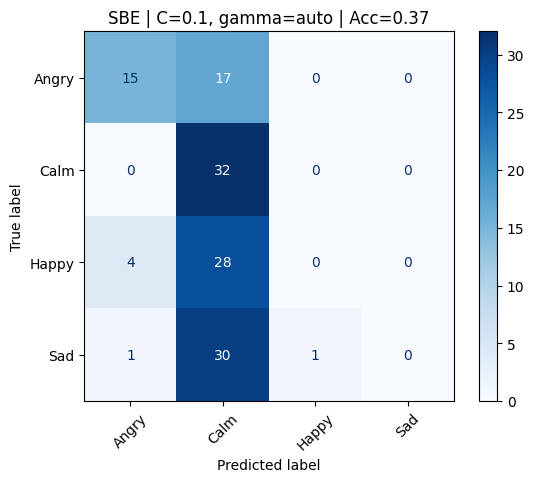

  C=0.1, gamma=auto: Accuracy = 0.3672


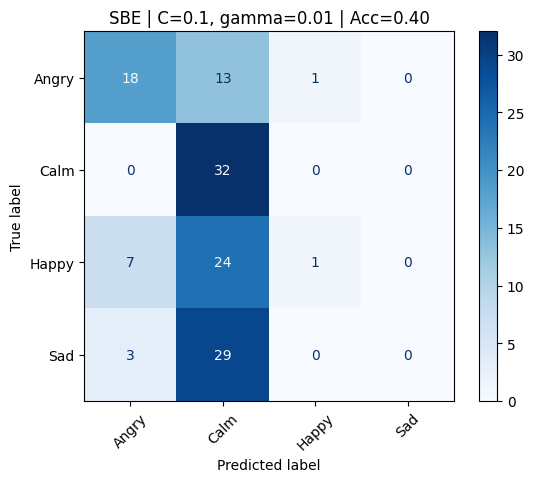

  C=0.1, gamma=0.01: Accuracy = 0.3984


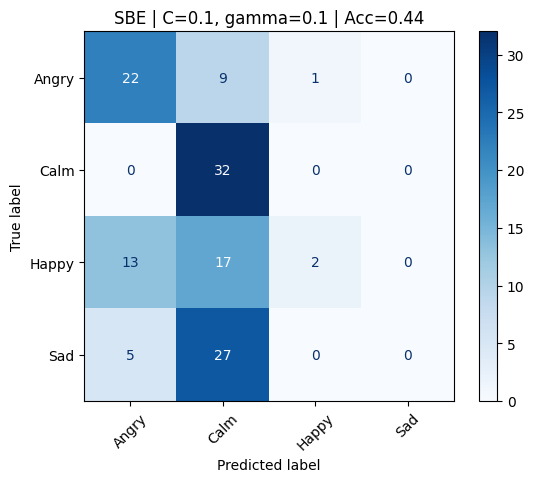

  C=0.1, gamma=0.1: Accuracy = 0.4375


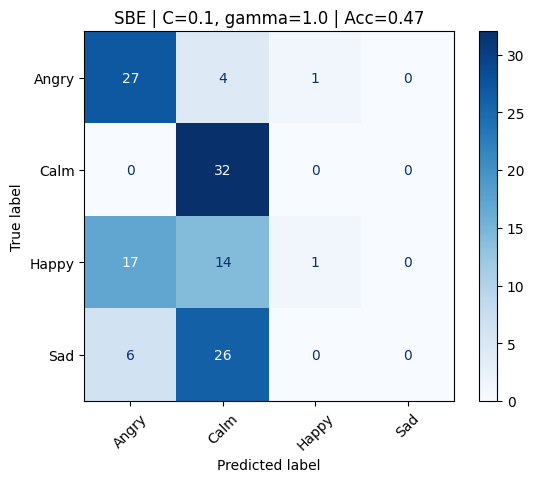

  C=0.1, gamma=1.0: Accuracy = 0.4688


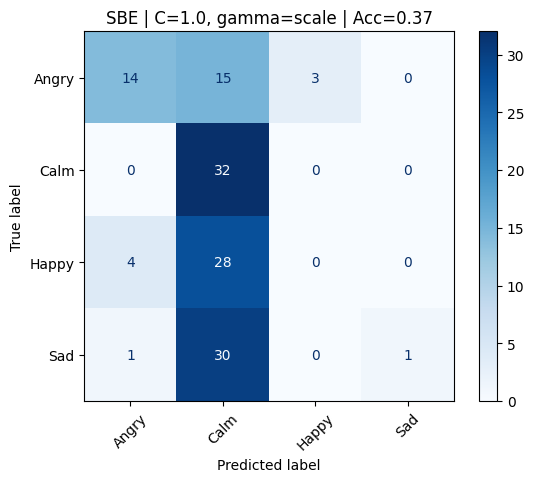

  C=1.0, gamma=scale: Accuracy = 0.3672


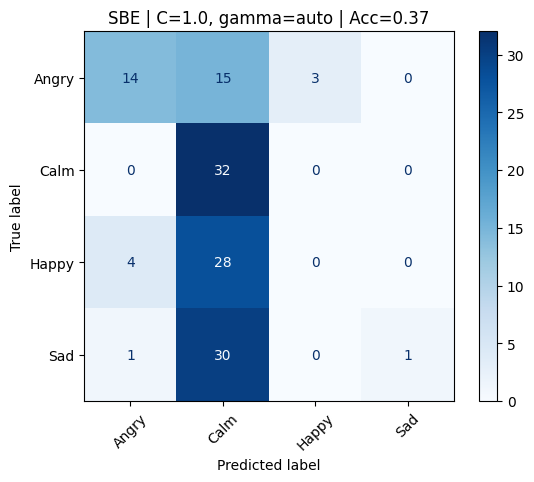

  C=1.0, gamma=auto: Accuracy = 0.3672


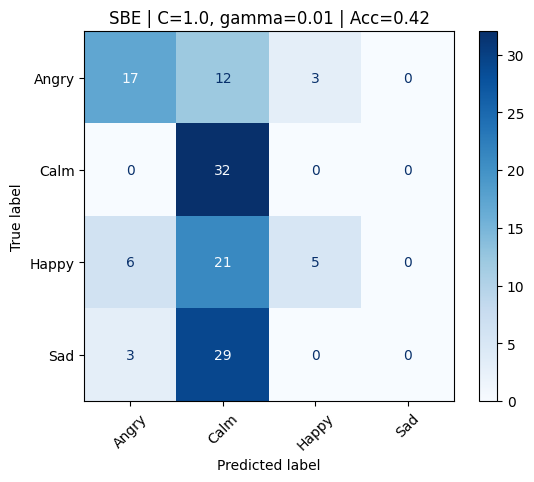

  C=1.0, gamma=0.01: Accuracy = 0.4219


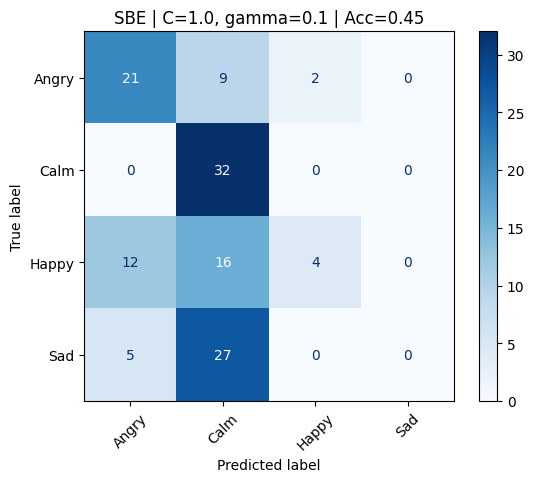

  C=1.0, gamma=0.1: Accuracy = 0.4453


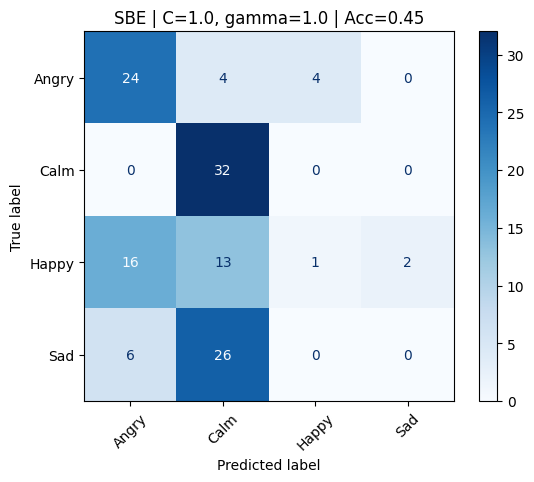

  C=1.0, gamma=1.0: Accuracy = 0.4453


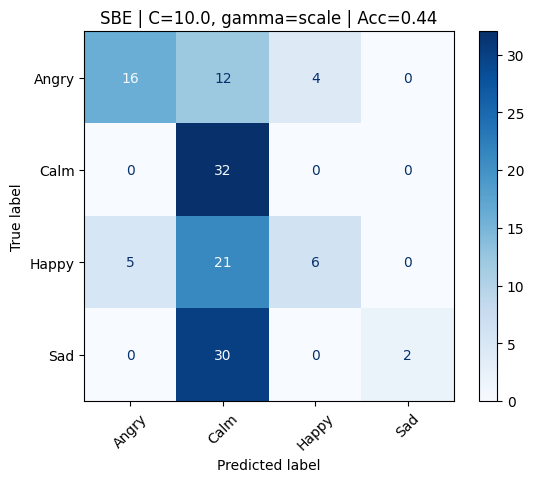

  C=10.0, gamma=scale: Accuracy = 0.4375


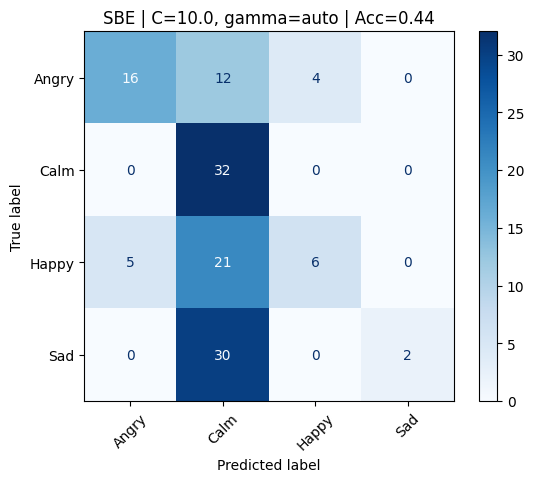

  C=10.0, gamma=auto: Accuracy = 0.4375


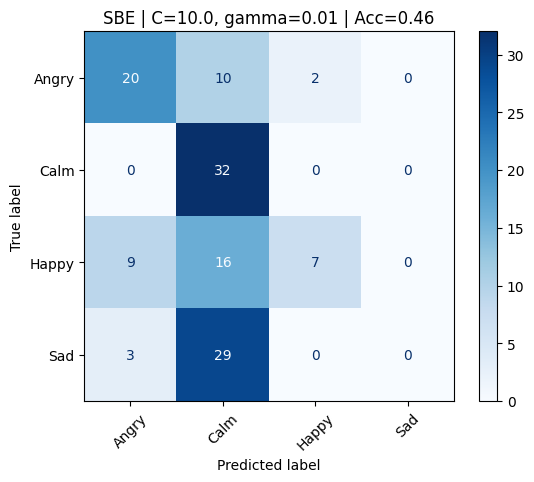

  C=10.0, gamma=0.01: Accuracy = 0.4609


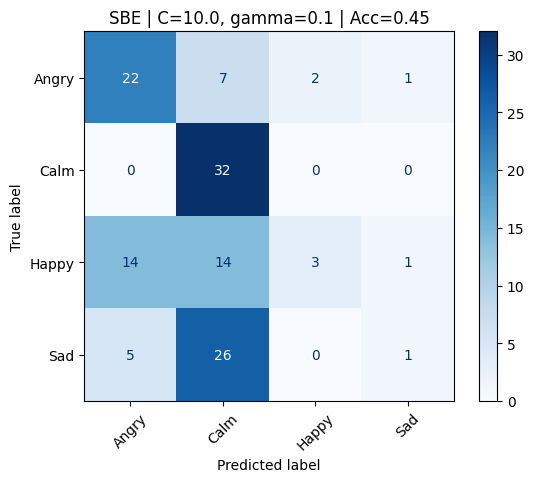

  C=10.0, gamma=0.1: Accuracy = 0.4531


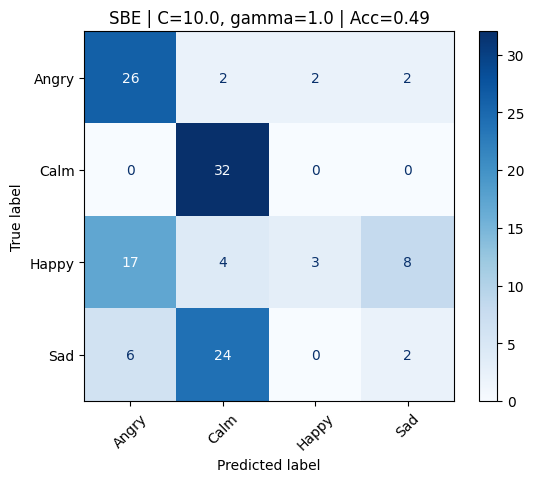

  C=10.0, gamma=1.0: Accuracy = 0.4922


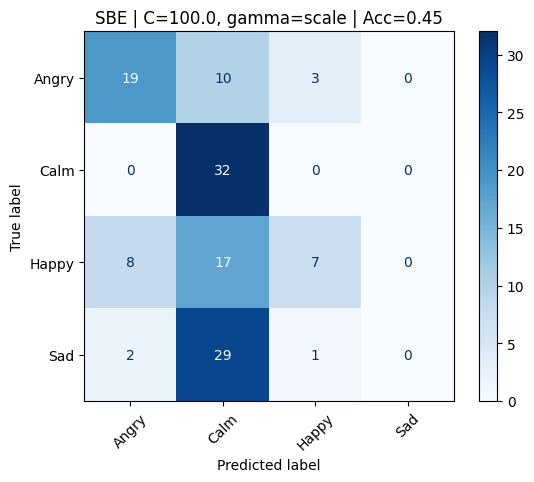

  C=100.0, gamma=scale: Accuracy = 0.4531


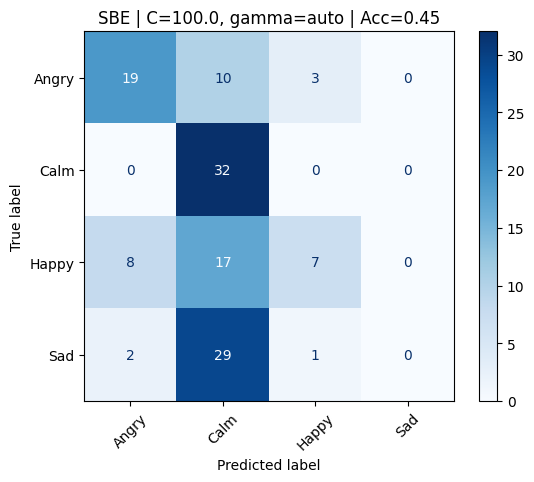

  C=100.0, gamma=auto: Accuracy = 0.4531


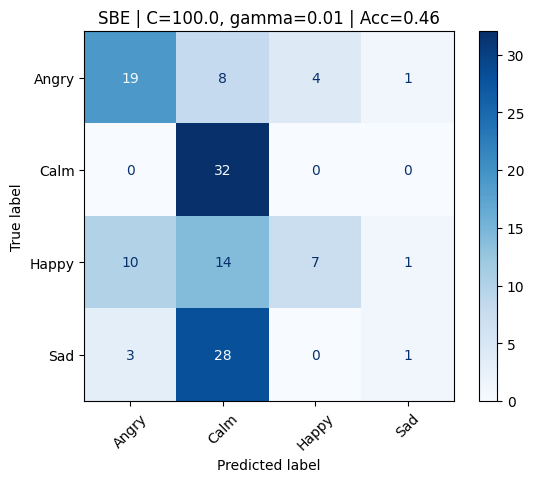

  C=100.0, gamma=0.01: Accuracy = 0.4609


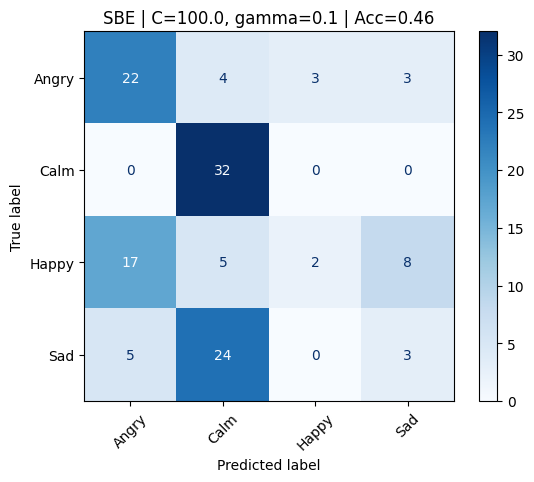

  C=100.0, gamma=0.1: Accuracy = 0.4609


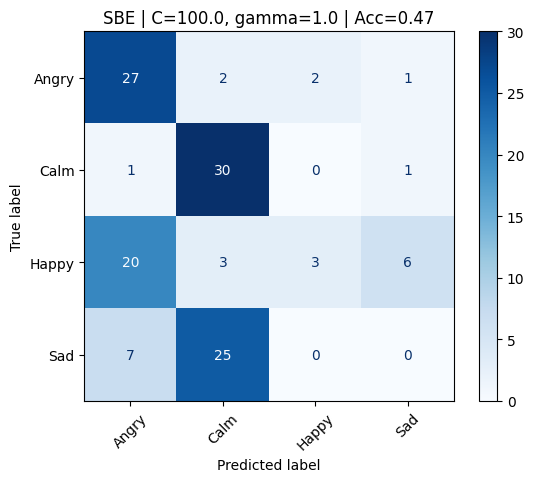

  C=100.0, gamma=1.0: Accuracy = 0.4688
  Best parameters for SBE: C=10.0, gamma=1.0 (Accuracy: 0.4922)
--------------------


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Define a range of C and gamma values to experiment with
C_values = [0.1, 1.0, 10.0, 100.0]
gamma_values = ['scale', 'auto', 0.01, 0.1, 1.0] # 'scale' and 'auto' are common options, plus specific values

# Prepare data in a dictionary for easy iteration (using the scaled data from previous steps)
feature_data_scaled = {
    'SC': (train_sc_scaled, test_sc_scaled),
    'SBW': (train_sbw_scaled, test_sbw_scaled),
    'SBE': (train_sbe_scaled, test_sbe_scaled)
}

# Labels are the same for all features
train_labels_data = train_labels
test_labels_data = test_labels

# Dictionary to store results: {feature_name: { (C, gamma): [accuracy, cm], ... }, ... }
experiment_results = {}

for feature_name, (X_train, X_test) in feature_data_scaled.items():
    print(f"--- Experimenting with {feature_name} features ---")
    experiment_results[feature_name] = {}
    for C in C_values:
        for gamma in gamma_values:
            print(f"  Training with C={C}, gamma={gamma}")
            # Instantiate SVM model
            svm_model = SVC(C=C, kernel='rbf', gamma=gamma)

            # Train the model
            svm_model.fit(X_train, train_labels_data)

            # Make predictions on the test data
            y_pred = svm_model.predict(X_test)

            # Calculate accuracy and confusion matrix
            accuracy = accuracy_score(test_labels_data, y_pred)
            cm = confusion_matrix(test_labels_data, y_pred, labels=np.unique(train_labels_data))
            print(f"  Accuracy: {accuracy:.4f}")

            # Store the result (accuracy and confusion matrix)
            experiment_results[feature_name][(C, gamma)] = [accuracy, cm]

print("\n--- Experiment Summary ---")
for feature_name, results in experiment_results.items():
    print(f"Results for {feature_name} features:")
    # Iterate through the results, unpacking key and value (which is the list [accuracy, cm])
    for (C, gamma), result_list in results.items():
        accuracy = result_list[0]
        cm = result_list[1]

        # Display confusion matrix as an image
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(train_labels_data))
        disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
        plt.title(f"{feature_name} | C={C}, gamma={gamma} | Acc={accuracy:.2f}")
        plt.show()
        print(f"  C={C}, gamma={gamma}: Accuracy = {accuracy:.4f}")

    # Find best parameters for this feature based on accuracy
    best_params, best_result_list = max(results.items(), key=lambda item: item[1][0]) # item[1][0] is the accuracy
    best_accuracy = best_result_list[0]
    print(f"  Best parameters for {feature_name}: C={best_params[0]}, gamma={best_params[1]} (Accuracy: {best_accuracy:.4f})")
    print("-" * 20)

Spectral Centroid (SC) Features:

The highest accuracy achieved with SC features was 0.5469.
This accuracy was obtained with several parameter combinations, including C=1.0, gamma='scale', C=1.0, gamma='auto', C=10.0, gamma='scale', C=10.0, gamma='auto', C=100.0, gamma='scale', and C=100.0, gamma='auto'.
The lowest accuracies were observed with smaller gamma values (0.01 and 0.1).
Spectral Bandwidth (SBW) Features:

The highest accuracy achieved with SBW features was 0.5000.
This accuracy was obtained with C=0.1, gamma='scale', C=0.1, gamma='auto', C=10.0, gamma='scale', C=10.0, gamma='auto', C=100.0, gamma='scale', and C=100.0, gamma='auto'.
Performance varied significantly with different gamma values, with 0.1 yielding a higher accuracy than 0.01 or 1.0 for C=0.1.
Spectral Band Energy (SBE) Features:

The highest accuracy achieved with SBE features was 0.4922.
This accuracy was obtained with C=10.0, gamma=1.0.
Unlike SC and SBW, the SBE features showed a trend where larger gamma values (0.1 and 1.0) generally resulted in higher accuracies compared to smaller gamma values (0.01) or 'scale'/'auto'.
Overall:

Comparing the best accuracies for each feature type, the Spectral Centroid (SC) features performed the best with a peak accuracy of 0.5469. The Spectral Bandwidth (SBW) features came second with 0.5000, and Spectral Band Energy (SBE) features were third with 0.4922 (at different parameters than the initial run).

This confirms the earlier finding that SC features appear to be the most effective among the three tested for this emotion recognition task using an RBF SVM. The experiment also shows that the choice of C and gamma parameters can influence the performance, and for SC and SBW, the default 'scale'/'auto' gamma often works well, while for SBE, a specific gamma value (1.0 in this experiment) yielded the best result.

# Task
Visualize mel-scale spectrograms for at least one audio clip per training/testing set per emotion class from the "EmotionSpeech" dataset.

## Select example audio files

### Subtask:
Choose at least one audio file for each emotion class from both the training and testing datasets.


**Reasoning**:
Define the base directory and find example files for each emotion and dataset split using glob, then store and print the selected file paths.



**Reasoning**:
Iterate through the selected example files, load each audio file, compute its mel-spectrogram, visualize the spectrogram, and add titles to the plots.



## Summary:

### Data Analysis Key Findings

*   At least one example audio file was successfully identified and selected for each emotion class ('Angry', 'Calm', 'Happy', 'Sad') in both the 'Train' and 'Test' datasets.
*   Mel-spectrograms were successfully computed and visualized for each selected example audio file from both the training and testing sets, covering all four emotion classes.

### Insights or Next Steps

*   The visualizations provide a qualitative understanding of the acoustic differences between emotion classes, which could be useful for feature engineering or model development.
*   Further analysis could involve comparing the spectrograms across different examples within the same emotion class or quantifying the differences between emotion classes using specific features derived from the spectrograms.


#Task 3.1 -1D CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from glob import glob
from tqdm.notebook import tqdm
import librosa
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import itertools
import random

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Paths - change if needed
TRAIN_DIR = "/content/drive/My Drive/Datasets/EmotionSpeech/Train"
TEST_DIR  = "/content/drive/My Drive/Datasets/EmotionSpeech/Test"

# Dataset parameters (same as assignment)
N_FRAMES = 200
HOP_LENGTH_SEC = 0.015

# Training params (tweak as needed)
BATCH_SIZE = 32
NUM_EPOCHS = 40
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)


Device: cuda


In [ ]:
# Adapted EmotionSpeechDataset: same logic as yours but allows computed mean/std (if provided)
from pydub import AudioSegment

class EmotionSpeechDataset(Dataset):
    def __init__(self, dataset_dir, n_frames=200, hop_length_in_sec=0.015, mean=None, std=None, sr_override=None):
        """
        dataset_dir: root folder with one subfolder per emotion class
        mean/std: optional global mean/std for normalization (if None, dataset will not normalize)
        sr_override: optional target sample rate forcing resampling (librosa.load will resample)
        """
        self.dataset_dir = dataset_dir
        self.emotions = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
        # Build list of (path, label)
        self.paths = []
        for i, e in enumerate(self.emotions):
            folder = os.path.join(dataset_dir, e)
            files = sorted([f for f in os.listdir(folder) if f.lower().endswith(('.wav', '.flac', '.mp3', '.m4a', '.ogg'))])
            for p in files:
                self.paths.append((os.path.join(folder, p), i))
        self.lengths = [len(os.listdir(os.path.join(dataset_dir, e))) for e in self.emotions]
        self.n_frames = n_frames
        self.hop_length_in_sec = hop_length_in_sec
        self.mean = mean
        self.std = std
        self.sr_override = sr_override

    def __len__(self):
        return len(self.paths)

    def index2label(self, index):
        # return label stored at index
        return self.paths[index][1]

    def index2signal(self, index):
        path, _ = self.paths[index]
        # Use librosa.load to handle resampling automatically (keeps consistent scaling to [-1,1])
        if self.sr_override is None:
            y, sr = librosa.load(path, sr=None)  # preserve native sr
        else:
            y, sr = librosa.load(path, sr=self.sr_override)
        hop_length = int(sr * self.hop_length_in_sec)
        n_samples = (self.n_frames + 1) * hop_length
        # ensure mono
        if y.ndim > 1:
            y = np.mean(y, axis=1)
        # pad or truncate
        if y.shape[0] >= n_samples:
            sig = y[:n_samples].astype(np.float32)
        else:
            sig = np.zeros(n_samples, dtype=np.float32)
            sig[:y.shape[0]] = y.astype(np.float32)
        # normalization using provided mean/std if available; else leave as-is
        if (self.mean is not None) and (self.std is not None):
            sig = (sig - self.mean) / self.std
        return sig

    def __getitem__(self, index):
        label = self.index2label(index)
        signal = self.index2signal(index)
        # return shape (1, N) for Conv1d
        return np.expand_dims(signal, axis=0).astype(np.float32), label


In [ ]:
def all_file_paths(root_dir):
    classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    filepaths = []
    for c in classes:
        folder = os.path.join(root_dir, c)
        files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.wav', '.flac', '.mp3', '.m4a', '.ogg'))])
        filepaths.extend(files)
    return filepaths

def compute_mean_std_over_dataset(file_paths, n_frames, hop_length_in_sec, sr_override=None):
    """
    Compute mean and std over fixed-length waveforms created from file_paths.
    Uses librosa.load (resamples if sr_override provided).
    """
    s = 0.0
    sq = 0.0
    count = 0
    # compute target n_samples from first file
    y0, sr0 = librosa.load(file_paths[0], sr=sr_override)
    sr = sr0
    target_samples = (n_frames + 1) * int(sr * hop_length_in_sec)
    for p in tqdm(file_paths, desc="Computing mean/std"):
        y, sr1 = librosa.load(p, sr=sr_override)
        if sr_override is None:
            sr = sr1
            target_samples = (n_frames + 1) * int(sr * hop_length_in_sec)
        if y.ndim > 1:
            y = np.mean(y, axis=1)
        if y.shape[0] >= target_samples:
            sig = y[:target_samples].astype(np.float64)
        else:
            sig = np.zeros(target_samples, dtype=np.float64)
            sig[:y.shape[0]] = y.astype(np.float64)
        s += sig.sum()
        sq += (sig ** 2).sum()
        count += sig.size
    mean = s / count
    var = (sq / count) - (mean ** 2)
    std = np.sqrt(max(var, 1e-12))
    return float(mean), float(std)

# collate_fn to make batches from (signal,label) tuples
def collate_fn(batch):
    # batch is list of (np.array shape (1,N), label)
    xs = [torch.from_numpy(b[0]) for b in batch]  # each is (1,N)
    ys = [b[1] for b in batch]
    X = torch.stack(xs, dim=0)  # (B,1,N)
    y = torch.tensor(ys, dtype=torch.long)
    return X, y

# Example: compute mean/std on training files
train_file_paths = all_file_paths(TRAIN_DIR)
print("Train files:", len(train_file_paths))
MEAN, STD = compute_mean_std_over_dataset(train_file_paths, N_FRAMES, HOP_LENGTH_SEC, sr_override=None)
print("Computed mean, std:", MEAN, STD)

# Create datasets with mean/std applied
train_dataset = EmotionSpeechDataset(TRAIN_DIR, n_frames=N_FRAMES, hop_length_in_sec=HOP_LENGTH_SEC, mean=MEAN, std=STD)
test_dataset  = EmotionSpeechDataset(TEST_DIR,  n_frames=N_FRAMES, hop_length_in_sec=HOP_LENGTH_SEC, mean=MEAN, std=STD)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)


Train files: 128


Computing mean/std:   0%|          | 0/128 [00:00<?, ?it/s]

Computed mean, std: -1.2402790827669446e-06 0.035945916081844526


In [ ]:
# Conv blocks and models (as you provided)
class ConvBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=None):
        super().__init__()
        if padding is None:
            padding = (kernel_size - 1) // 2
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class GlobalPoolClassifier(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(in_ch, num_classes)
    def forward(self, x):
        x = self.pool(x)             # (B, C, 1)
        x = x.view(x.size(0), -1)    # (B, C)
        return self.fc(x)

def first_kernel_from_sr(sr: int, ms = 10):
    k = int(sr * (ms / 1000.0))
    if k % 2 == 0:
        k += 1
    return max(3, k)

class Conv1DSmall(nn.Module):
    def __init__(self, num_classes=4, sr=16000):
        super().__init__()
        fk = first_kernel_from_sr(sr, ms=10)
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=fk, stride=4, padding=(fk-1)//2, bias=False),
            nn.BatchNorm1d(64), nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )
        self.layer2 = nn.Sequential(
            ConvBlock1D(64, 128, kernel_size=3),
            ConvBlock1D(128, 128, kernel_size=3),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )
        self.layer3 = nn.Sequential(
            ConvBlock1D(128, 256, kernel_size=3),
            ConvBlock1D(256, 256, kernel_size=3)
        )
        self.classifier = GlobalPoolClassifier(256, num_classes)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.classifier(x)
        return x

class Conv1DMedium(nn.Module):
    def __init__(self, num_classes=4, sr=16000):
        super().__init__()
        fk = first_kernel_from_sr(sr, ms=10)
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=fk, stride=4, padding=(fk-1)//2, bias=False),
            nn.BatchNorm1d(64), nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )
        self.blocks = nn.Sequential(
            ConvBlock1D(64, 128, 3),
            ConvBlock1D(128, 128, 3),
            nn.MaxPool1d(4,4),

            ConvBlock1D(128, 256, 3),
            ConvBlock1D(256, 256, 3),
            ConvBlock1D(256, 256, 3),
            nn.MaxPool1d(4,4),

            ConvBlock1D(256, 512, 3),
            ConvBlock1D(512, 512, 3)
        )
        self.classifier = GlobalPoolClassifier(512, num_classes)
    def forward(self, x):
        x = self.layer1(x)
        x = self.blocks(x)
        x = self.classifier(x)
        return x

class Conv1DLarge(nn.Module):
    def __init__(self, num_classes=4, sr=16000):
        super().__init__()
        fk = first_kernel_from_sr(sr, ms=10)
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=fk, stride=4, padding=(fk-1)//2, bias=False),
            nn.BatchNorm1d(64), nn.ReLU(inplace=True),
            nn.MaxPool1d(4,4)
        )
        self.blocks = nn.Sequential(
            ConvBlock1D(64, 128, 3),
            ConvBlock1D(128, 128, 3),
            nn.MaxPool1d(4,4),

            ConvBlock1D(128, 256, 3),
            ConvBlock1D(256, 256, 3),
            ConvBlock1D(256, 256, 3),
            ConvBlock1D(256, 256, 3),
            nn.MaxPool1d(4,4),

            ConvBlock1D(256, 512, 3),
            ConvBlock1D(512, 512, 3),
            ConvBlock1D(512, 512, 3)
        )
        self.classifier = GlobalPoolClassifier(512, num_classes)
    def forward(self, x):
        x = self.layer1(x)
        x = self.blocks(x)
        x = self.classifier(x)
        return x


In [ ]:
from sklearn.metrics import classification_report

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    preds = []
    trues = []
    for X, y in loader:
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        preds.append(out.detach().cpu().argmax(dim=1).numpy())
        trues.append(y.detach().cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return running_loss / len(loader.dataset), accuracy_score(trues, preds)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds = []
    trues = []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            out = model(X)
            loss = criterion(out, y)
            running_loss += loss.item() * X.size(0)
            preds.append(out.cpu().argmax(dim=1).numpy())
            trues.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    cm = confusion_matrix(trues, preds)
    return running_loss / len(loader.dataset), accuracy_score(trues, preds), cm, classification_report(trues, preds, target_names=train_dataset.emotions, zero_division=0)


In [ ]:
# Choose model: Conv1DSmall, Conv1DMedium, Conv1DLarge
model = Conv1DMedium(num_classes=len(train_dataset.emotions), sr=16000).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0
best_model_path = "best_conv1d_model.pth"

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, cm_val, report = eval_epoch(model, test_loader, criterion, DEVICE)
    train_losses.append(train_loss); train_accs.append(train_acc)
    val_losses.append(val_loss); val_accs.append(val_acc)
    scheduler.step(val_acc)
    print(f"Epoch {epoch}/{NUM_EPOCHS} - train loss: {train_loss:.4f} acc: {train_acc:.4f} | val loss: {val_loss:.4f} acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model.state_dict(), 'mean': MEAN, 'std': STD, 'emotions': train_dataset.emotions}, best_model_path)
        print("Saved best model (acc {:.4f})".format(best_val_acc))

# final evaluation
print("Best val acc:", best_val_acc)
_, test_acc, test_cm, test_report = eval_epoch(model, test_loader, criterion, DEVICE)
print("Test Acc:", test_acc)
print("Classification report:\n", test_report)

Epoch 1/40 - train loss: 1.2199 acc: 0.3047 | val loss: 1.3698 acc: 0.3125
Saved best model (acc 0.3125)
Epoch 2/40 - train loss: 1.1024 acc: 0.4688 | val loss: 1.4628 acc: 0.2812
Epoch 3/40 - train loss: 1.0260 acc: 0.5547 | val loss: 1.4806 acc: 0.3438
Saved best model (acc 0.3438)
Epoch 4/40 - train loss: 0.9950 acc: 0.5469 | val loss: 1.6841 acc: 0.2812
Epoch 5/40 - train loss: 0.9315 acc: 0.5859 | val loss: 1.9411 acc: 0.2656
Epoch 6/40 - train loss: 0.8439 acc: 0.6250 | val loss: 1.9723 acc: 0.2344
Epoch 7/40 - train loss: 0.8611 acc: 0.5938 | val loss: 1.5651 acc: 0.3125
Epoch 8/40 - train loss: 0.8113 acc: 0.6719 | val loss: 1.1866 acc: 0.3828
Saved best model (acc 0.3828)
Epoch 9/40 - train loss: 0.6951 acc: 0.7344 | val loss: 1.1816 acc: 0.3984
Saved best model (acc 0.3984)
Epoch 10/40 - train loss: 0.6691 acc: 0.6875 | val loss: 1.4655 acc: 0.3359
Epoch 11/40 - train loss: 0.5992 acc: 0.7734 | val loss: 1.8747 acc: 0.3047
Epoch 12/40 - train loss: 0.6000 acc: 0.7734 | val lo

In [ ]:
# Choose model: Conv1DSmall, Conv1DMedium, Conv1DLarge
model = Conv1DMedium(num_classes=len(train_dataset.emotions), sr=16000).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0
best_model_path = "best_conv1d_model.pth"

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, cm_val, report = eval_epoch(model, test_loader, criterion, DEVICE)
    train_losses.append(train_loss); train_accs.append(train_acc)
    val_losses.append(val_loss); val_accs.append(val_acc)
    scheduler.step(val_acc)
    print(f"Epoch {epoch}/{NUM_EPOCHS} - train loss: {train_loss:.4f} acc: {train_acc:.4f} | val loss: {val_loss:.4f} acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model.state_dict(), 'mean': MEAN, 'std': STD, 'emotions': train_dataset.emotions}, best_model_path)
        print("Saved best model (acc {:.4f})".format(best_val_acc))

# final evaluation
print("Best val acc:", best_val_acc)
_, test_acc, test_cm, test_report = eval_epoch(model, test_loader, criterion, DEVICE)
print("Test Acc:", test_acc)
print("Classification report:\n", test_report)

Epoch 1/40 - train loss: 1.3039 acc: 0.3828 | val loss: 1.3329 acc: 0.3281
Saved best model (acc 0.3281)
Epoch 2/40 - train loss: 1.0841 acc: 0.4844 | val loss: 1.3775 acc: 0.3359
Saved best model (acc 0.3359)
Epoch 3/40 - train loss: 0.9934 acc: 0.4922 | val loss: 1.5380 acc: 0.2969
Epoch 4/40 - train loss: 0.9647 acc: 0.5625 | val loss: 1.5474 acc: 0.3203
Epoch 5/40 - train loss: 0.8393 acc: 0.6641 | val loss: 1.4579 acc: 0.3438
Saved best model (acc 0.3438)
Epoch 6/40 - train loss: 0.8296 acc: 0.6328 | val loss: 1.4080 acc: 0.3438
Epoch 7/40 - train loss: 0.8550 acc: 0.6875 | val loss: 0.9939 acc: 0.4609
Saved best model (acc 0.4609)
Epoch 8/40 - train loss: 0.7703 acc: 0.6641 | val loss: 1.0553 acc: 0.4609
Epoch 9/40 - train loss: 0.6929 acc: 0.7266 | val loss: 1.5401 acc: 0.2969
Epoch 10/40 - train loss: 0.6932 acc: 0.7656 | val loss: 1.3855 acc: 0.3750
Epoch 11/40 - train loss: 0.6523 acc: 0.7500 | val loss: 1.1601 acc: 0.4375
Epoch 12/40 - train loss: 0.5519 acc: 0.8281 | val lo

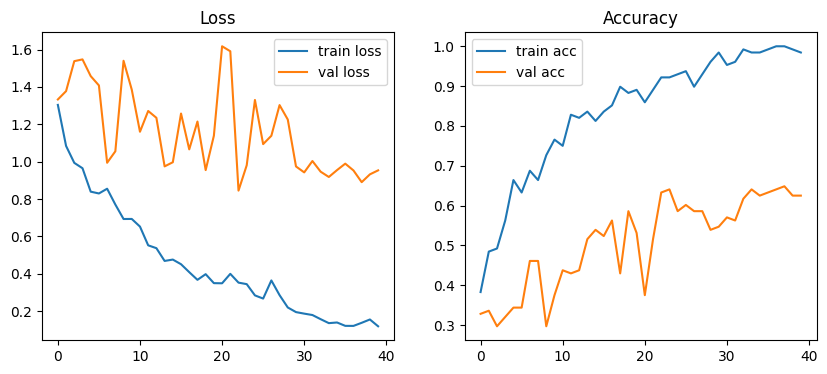

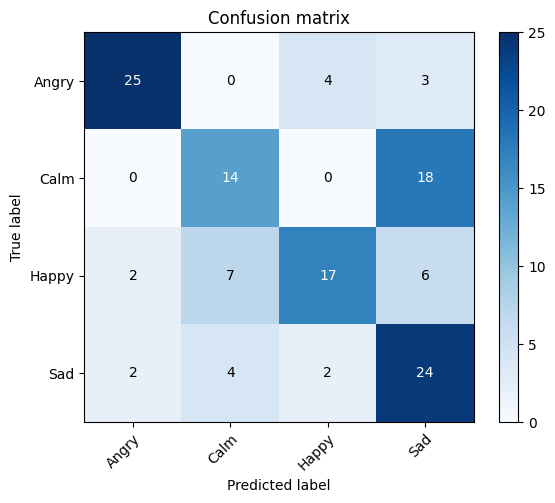

In [ ]:
# Learning curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs, label='train acc')
plt.plot(val_accs, label='val acc')
plt.legend(); plt.title('Accuracy')
plt.show()

# Confusion matrix (from last eval)
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names, ylabel='True label', xlabel='Predicted label',
           title='Confusion matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()

plot_confusion_matrix(test_cm, train_dataset.emotions)


#Task 3.2- 2D CNN

In [ ]:
# In Colab run once if libraries missing
!pip install librosa torchvision pillow matplotlib tqdm
!apt-get install -y libsndfile1 ffmpeg


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.2).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import os
from glob import glob
import numpy as np
import librosa
import cv2 as cv
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import itertools
import random

# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Paths (change to your dataset locations)
# AUDIO_TRAIN_DIR = "/content/drive/My Drive/Datasets/EmotionSpeech/Train"
# AUDIO_TEST_DIR  = "/content/drive/My Drive/Datasets/EmotionSpeech/Test"
IMAGE_TRAIN_DIR = "/content/drive/My Drive/Datasets/SpecImages/Train"
IMAGE_TEST_DIR  = "/content/drive/My Drive/Datasets/SpecImages/Test"

# Audio -> mel spectrogram params
N_MELS = 3401
N_FFT = 16384
HOP_DURATION = 0.015
FMIN = 300.0
FMAX = 3400.0
POWER = 1  # IMPORTANT: assignment requires power=1 for spectrogram images

# Image transform params
IMG_SIZE = (150, 50)  # (height, width) as in transforms.Resize((150,50)) — torchvision uses (H,W)
BATCH_SIZE = 32
NUM_WORKERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 4  # Angry, Calm, Happy, Sad (ensure folders present and alphabetically named if using ImageFolder)

print("Device:", DEVICE)


Device: cuda


In [ ]:
# scale and save utilities (as in assignment)
def scale(X):
    X_min = X.min()
    X_max = X.max()
    if X_max - X_min < 1e-9:
        X_scaled = np.zeros_like(X, dtype=np.uint8)
        return X_scaled
    X_scaled = (X - X_min) / (X_max - X_min) * 255.0
    X_scaled = X_scaled.astype(np.uint8)
    return X_scaled

def spectrogram2image(X, filename):
    """
    X: mel-spectrogram (power) matrix, shape (n_mels, T)
    Save log-scaled (dB-like) image to filename (grayscale).
    """
    # safe log transform (equivalent to librosa.power_to_db for small values)
    X_db = np.log(X + 1e-9)
    X_scaled = scale(X_db)
    # cv.imwrite expects (H, W) for grayscale; ensure dtype uint8
    cv.imwrite(filename, X_scaled)


In [ ]:
def make_spectrogram_image(y, sr, n_mels=N_MELS, n_fft=N_FFT, hop_duration=HOP_DURATION, power=POWER, fmin=FMIN, fmax=FMAX):
    hop_length = int(sr * hop_duration)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                       n_mels=n_mels, power=power, fmin=fmin, fmax=fmax)
    return S  # (n_mels, T)

def process_audio_folder_to_images(audio_root, image_root):
    """
    Walk audio_root/<emotion>/*.wav -> produce image_root/<emotion>/*.png
    Creates directories as needed. Skips files if image already exists.
    """
    os.makedirs(image_root, exist_ok=True)
    classes = sorted([d for d in os.listdir(audio_root) if os.path.isdir(os.path.join(audio_root, d))])
    print("Found emotion classes:", classes)
    for c in classes:
        aud_folder = os.path.join(audio_root, c)
        img_folder = os.path.join(image_root, c)
        os.makedirs(img_folder, exist_ok=True)
        files = sorted([f for f in os.listdir(aud_folder) if f.lower().endswith(('.wav', '.flac', '.mp3', '.m4a', '.ogg'))])
        for fname in tqdm(files, desc=f"Processing {c}", leave=False):
            aud_path = os.path.join(aud_folder, fname)
            base = os.path.splitext(fname)[0]
            out_path = os.path.join(img_folder, base + ".png")
            if os.path.exists(out_path):
                continue  # skip existing
            try:
                y, sr = librosa.load(aud_path, sr=None)  # preserve SR
                S = make_spectrogram_image(y, sr)
                # Convert S to image (log + scale)
                spectrogram2image(S, out_path)
            except Exception as e:
                print("Error processing", aud_path, e)

# Run once to generate images (may take some time)
process_audio_folder_to_images(TRAIN_DIR, IMAGE_TRAIN_DIR)
process_audio_folder_to_images(TEST_DIR, IMAGE_TEST_DIR)
print("Image generation complete.")


Found emotion classes: ['Angry', 'Calm', 'Happy', 'Sad']


Processing Angry:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing Calm:   0%|          | 0/32 [00:00<?, ?it/s]

Processing Happy:   0%|          | 0/32 [00:00<?, ?it/s]

Processing Sad:   0%|          | 0/32 [00:00<?, ?it/s]

Found emotion classes: ['Angry', 'Calm', 'Happy', 'Sad']


Processing Angry:   0%|          | 0/32 [00:00<?, ?it/s]

Processing Calm:   0%|          | 0/32 [00:00<?, ?it/s]

Processing Happy:   0%|          | 0/32 [00:00<?, ?it/s]

Processing Sad:   0%|          | 0/32 [00:00<?, ?it/s]

Image generation complete.


In [ ]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

# transforms: note Resize takes (H,W)
train_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.Grayscale(num_output_channels=1),
    # Augmentation (optional). Keep conservative for spectrograms:
    T.RandomApply([T.RandomCrop((IMG_SIZE[0], IMG_SIZE[1]))], p=0.2),  # small random crop
    T.RandomHorizontalFlip(p=0.2),  # time-axis flip (horizontal) is like time-reversal: use with caution
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

test_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

train_dataset = ImageFolder(IMAGE_TRAIN_DIR, transform=train_transform)
test_dataset  = ImageFolder(IMAGE_TEST_DIR, transform=test_transform)

print("Classes (ImageFolder):", train_dataset.classes)  # alphabetical order used by ImageFolder

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


Classes (ImageFolder): ['Angry', 'Calm', 'Happy', 'Sad']


Emotion classes found: ['Angry', 'Calm', 'Happy', 'Sad']

Displaying example spectrogram images:

--- Train Examples ---


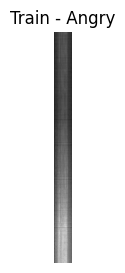

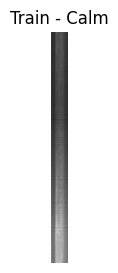

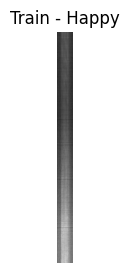

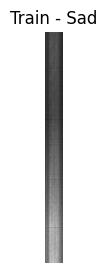


--- Test Examples ---


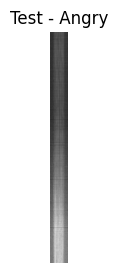

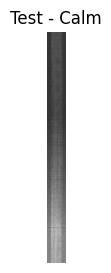

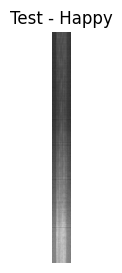

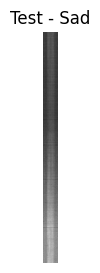

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from glob import glob

# Define the directories where the spectrogram images were saved
image_train_dir = "/content/drive/My Drive/Datasets/SpecImages/Train"
image_test_dir = "/content/drive/My Drive/Datasets/SpecImages/Test"

# Emotion classes (assuming alphabetical order based on ImageFolder)
emotion_classes = sorted(os.listdir(image_train_dir))
if '.ipynb_checkpoints' in emotion_classes:
    emotion_classes.remove('.ipynb_checkpoints')

print("Emotion classes found:", emotion_classes)

# Select one example image path for each emotion in train and test sets
example_image_paths = {}
for split, base_dir in [('Train', image_train_dir), ('Test', image_test_dir)]:
    example_image_paths[split] = {}
    for emotion in emotion_classes:
        emotion_folder = os.path.join(base_dir, emotion)
        # Get all png files in the folder
        image_files = glob(os.path.join(emotion_folder, "*.png"))
        if image_files:
            # Take the first file as an example
            example_image_paths[split][emotion] = image_files[0]
        else:
            example_image_paths[split][emotion] = None
            print(f"Warning: No .png files found for {split}/{emotion}")


# Display the example images
print("\nDisplaying example spectrogram images:")
for split in ['Train', 'Test']:
    print(f"\n--- {split} Examples ---")
    for emotion in emotion_classes:
        img_path = example_image_paths[split][emotion]
        if img_path and os.path.exists(img_path):
            img = mpimg.imread(img_path)
            plt.figure(figsize=(4, 3))
            plt.imshow(img, cmap='gray')
            plt.title(f"{split} - {emotion}")
            plt.axis('off') # Hide axes
            plt.show()
        elif img_path is None:
             print(f"No example image available for {split}/{emotion}")
        else:
            print(f"Example image not found: {img_path}")

In [ ]:
class CNN2D(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # input: (B, 1, H, W) where H=150, W=50 (as chosen)
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2)),  # (H/2, W/2)

            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2)),  # (H/4, W/4)

            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2)),  # (H/8, W/8)

            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2)),  # (H/16, W/16)
            nn.Dropout(0.3)
        )
        # compute flatten size given IMG_SIZE (H,W)
        with torch.no_grad():
            dummy = torch.zeros(1,1,IMG_SIZE[0], IMG_SIZE[1])
            feat = self.features(dummy)
            n_flat = int(np.prod(feat.shape[1:]))
        self.classifier = nn.Sequential(
            nn.Linear(n_flat, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNN2D(num_classes=len(train_dataset.classes)).to(DEVICE)
print(model)


CNN2D(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
import torchvision.models as models

def build_resnet18_1ch(num_classes=NUM_CLASSES, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    w = model.conv1.weight.data  # (64,3,k,k)
    new_conv1 = nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size,
                          stride=model.conv1.stride, padding=model.conv1.padding, bias=False)
    # initialize by averaging RGB weights
    new_conv1.weight.data = w.mean(dim=1, keepdim=True)
    model.conv1 = new_conv1
    in_feats = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_feats, num_classes)
    )
    return model

In [ ]:
model = build_resnet18_1ch(num_classes=NUM_CLASSES, pretrained=True).to(DEVICE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    preds, trues = [], []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        preds.append(out.detach().cpu().argmax(dim=1).numpy())
        trues.append(y.detach().cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return running_loss / len(loader.dataset), accuracy_score(trues, preds)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds, trues = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            loss = criterion(out, y)
            running_loss += loss.item() * X.size(0)
            preds.append(out.cpu().argmax(dim=1).numpy())
            trues.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    cm = confusion_matrix(trues, preds)
    return running_loss / len(loader.dataset), accuracy_score(trues, preds), cm, classification_report(trues, preds, target_names=train_dataset.classes, zero_division=0)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

EPOCHS = 40
best_acc = 0.0
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, cm, report = eval_epoch(model, test_loader, criterion, DEVICE)
    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
    scheduler.step(val_acc)
    print(f"Epoch {epoch}/{EPOCHS} | train loss {train_loss:.4f} acc {train_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model_state": model.state_dict(), "classes": train_dataset.classes}, "best_2dcnn.pth")
        print(f"Saved best model (acc {best_acc:.4f})")
print("Training finished. Best val acc:", best_acc)

Epoch 1/40 | train loss 1.8358 acc 0.2891 | val loss 2.6540 acc 0.2500
Saved best model (acc 0.2500)
Epoch 2/40 | train loss 1.0504 acc 0.6016 | val loss 2.5075 acc 0.2500
Epoch 3/40 | train loss 0.8202 acc 0.6484 | val loss 3.7501 acc 0.2500
Epoch 4/40 | train loss 0.4514 acc 0.8438 | val loss 2.5325 acc 0.3750
Saved best model (acc 0.3750)
Epoch 5/40 | train loss 0.3615 acc 0.8516 | val loss 2.2589 acc 0.2969
Epoch 6/40 | train loss 0.3329 acc 0.8750 | val loss 3.6001 acc 0.2812
Epoch 7/40 | train loss 0.3512 acc 0.8750 | val loss 3.9654 acc 0.3203
Epoch 8/40 | train loss 0.1488 acc 0.9531 | val loss 5.9606 acc 0.2656
Epoch 9/40 | train loss 0.0778 acc 0.9844 | val loss 7.5591 acc 0.2500
Epoch 10/40 | train loss 0.0883 acc 0.9609 | val loss 6.5786 acc 0.2578
Epoch 11/40 | train loss 0.0961 acc 0.9609 | val loss 5.3655 acc 0.2969
Epoch 12/40 | train loss 0.1023 acc 0.9766 | val loss 4.5149 acc 0.3516
Epoch 13/40 | train loss 0.0696 acc 0.9766 | val loss 3.9612 acc 0.3594
Epoch 14/40 |

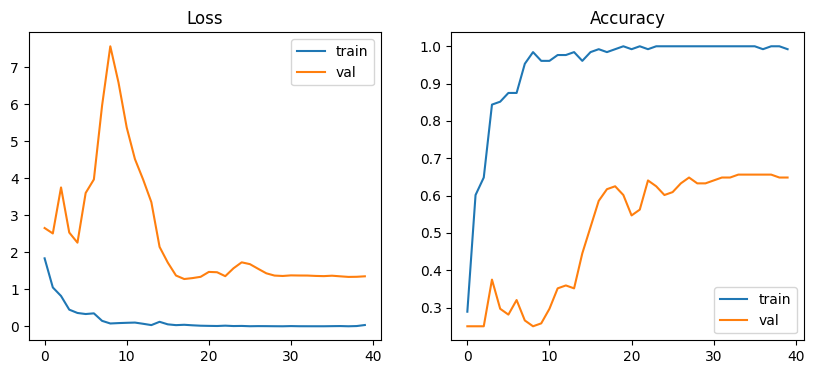

Test Acc: 0.65625
Classification report:
               precision    recall  f1-score   support

       Angry       0.63      0.81      0.71        32
        Calm       0.77      0.62      0.69        32
       Happy       0.78      0.56      0.65        32
         Sad       0.53      0.62      0.57        32

    accuracy                           0.66       128
   macro avg       0.68      0.66      0.66       128
weighted avg       0.68      0.66      0.66       128



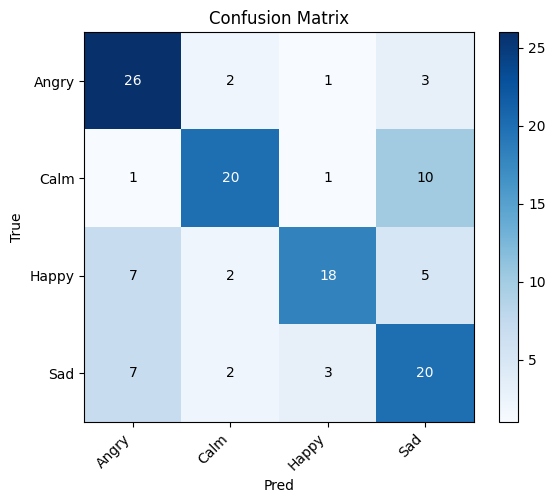

In [ ]:
# plot curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history["train_loss"], label='train'); plt.plot(history["val_loss"], label='val'); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history["train_acc"], label='train'); plt.plot(history["val_acc"], label='val'); plt.title("Accuracy"); plt.legend()
plt.show()

# load best and evaluate
checkpoint = torch.load("best_2dcnn.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state"])
_, test_acc, test_cm, test_report = eval_epoch(model, test_loader, criterion, DEVICE)
print("Test Acc:", test_acc)
print("Classification report:\n", test_report)

# confusion matrix plot
def plot_cm(cm, classes):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(classes)), yticks=np.arange(len(classes)), xticklabels=classes, yticklabels=classes, ylabel='True', xlabel='Pred', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

plot_cm(test_cm, train_dataset.classes)


#Introducing DataAugmentation

In [ ]:
# ----------------------------
# SpecAugment-like Augmentations
# ----------------------------
class TimeMasking:
    def __init__(self, max_mask_width=6, p=0.1):
        self.max_mask_width = max_mask_width
        self.p = p
    def __call__(self, x):
        # x: tensor (C, H, W) where W is time axis
        if random.random() > self.p:
            return x
        _, H, W = x.shape
        w = random.randint(1, min(self.max_mask_width, max(1, W//2)))
        if w <= 0:
            return x
        start = random.randint(0, W - w)
        x[:, :, start:start+w] = 0.0
        return x

class FrequencyMasking:
    def __init__(self, max_mask_height=40, p=0.15):
        self.max_mask_height = max_mask_height
        self.p = p
    def __call__(self, x):
        # x: tensor (C, H, W) where H is freq axis
        if random.random() > self.p:
            return x
        _, H, W = x.shape
        h = random.randint(1, min(self.max_mask_height, max(1, H//2)))
        if h <= 0:
            return x
        start = random.randint(0, H - h)
        x[:, start:start+h, :] = 0.0
        return x

def random_time_shift(x, max_shift_fraction=0.1, p=0.1):
    # shift along W axis
    if random.random() > p:
        return x
    _, H, W = x.shape
    max_shift = int(W * max_shift_fraction)
    if max_shift < 1:
        return x
    shift = random.randint(-max_shift, max_shift)
    return torch.roll(x, shifts=shift, dims=2)

# ----------------------------
# Transforms (train & test)
# ----------------------------
import torchvision.transforms as T

train_transform_aug = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9,1.0)),
    # transforms.RandomHorizontalFlip(p=0.25),    # careful: reverses time
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * (0.8 + 0.4*torch.rand(1))),  # random gain
    transforms.Lambda(lambda x: random_time_shift(x, max_shift_fraction=0.08, p=0.7)),
    transforms.Lambda(lambda x: TimeMasking(max_mask_width=8, p=0.3)(x)),
    transforms.Lambda(lambda x: FrequencyMasking(max_mask_height=40, p=0.6)(x)),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
# ----------------------------
# Datasets & loaders
# ----------------------------
train_ds = datasets.ImageFolder(IMAGE_TRAIN_DIR, transform=train_transform_aug)
test_ds  = datasets.ImageFolder(IMAGE_TEST_DIR, transform=test_transform)
print("Classes:", train_ds.classes)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


Classes: ['Angry', 'Calm', 'Happy', 'Sad']


In [ ]:
# Label smoothing if available
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # if torch supports it; else use plain CE

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
# Use CosineAnnealingLR or ReduceLROnPlateau
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))


/tmp/ipython-input-1337299067.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))


In [ ]:
EPOCHS = 40
best_acc = 0.0
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # if torch supports it; else use plain CE
# optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
# Use CosineAnnealingLR or ReduceLROnPlateau
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Mixed precision scaler
# scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))


for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, cm, report = eval_epoch(model, test_loader, criterion, DEVICE)
    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
    # scheduler.step(val_acc) # Remove this line to disable the scheduler step
    print(f"Epoch {epoch}/{EPOCHS} | train loss {train_loss:.4f} acc {train_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model_state": model.state_dict(), "classes": train_dataset.classes}, "best_2dcnn.pth")
        print(f"Saved best model (acc {best_acc:.4f})")
print("Training finished. Best val acc:", best_acc)

Epoch 1/40 | train loss 0.9366 acc 0.6641 | val loss 2.3821 acc 0.3984
Saved best model (acc 0.3984)
Epoch 2/40 | train loss 0.8247 acc 0.7109 | val loss 2.9694 acc 0.3203
Epoch 3/40 | train loss 0.7717 acc 0.7578 | val loss 2.9448 acc 0.3125
Epoch 4/40 | train loss 0.8180 acc 0.7812 | val loss 2.5906 acc 0.3203
Epoch 5/40 | train loss 0.7903 acc 0.7422 | val loss 2.2119 acc 0.3516
Epoch 6/40 | train loss 0.7687 acc 0.7969 | val loss 2.2081 acc 0.3672
Epoch 7/40 | train loss 0.7090 acc 0.8047 | val loss 2.6127 acc 0.3516
Epoch 8/40 | train loss 0.7943 acc 0.7422 | val loss 3.0702 acc 0.3516
Epoch 9/40 | train loss 0.7182 acc 0.7891 | val loss 3.1768 acc 0.3516
Epoch 10/40 | train loss 0.6643 acc 0.8672 | val loss 2.9211 acc 0.3828
Epoch 11/40 | train loss 0.6992 acc 0.8438 | val loss 2.7031 acc 0.3750
Epoch 12/40 | train loss 0.7316 acc 0.8359 | val loss 2.5943 acc 0.3906
Epoch 13/40 | train loss 0.6778 acc 0.8047 | val loss 2.4438 acc 0.3828
Epoch 14/40 | train loss 0.7045 acc 0.8125 

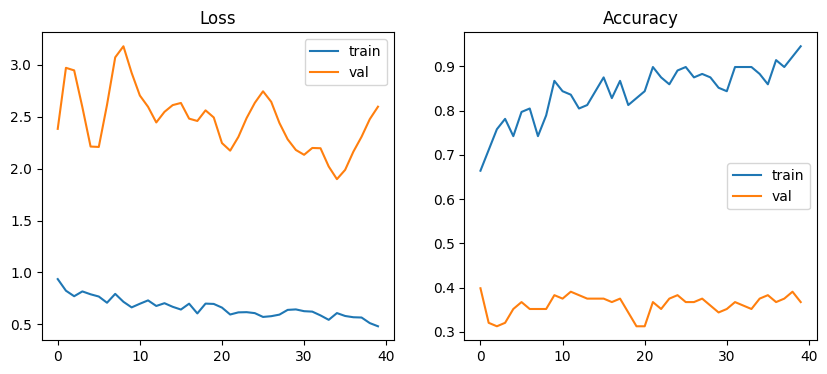

Test Acc: 0.3984375
Classification report:
               precision    recall  f1-score   support

       Angry       0.83      0.16      0.26        32
        Calm       0.36      0.94      0.52        32
       Happy       0.00      0.00      0.00        32
         Sad       0.43      0.50      0.46        32

    accuracy                           0.40       128
   macro avg       0.41      0.40      0.31       128
weighted avg       0.41      0.40      0.31       128



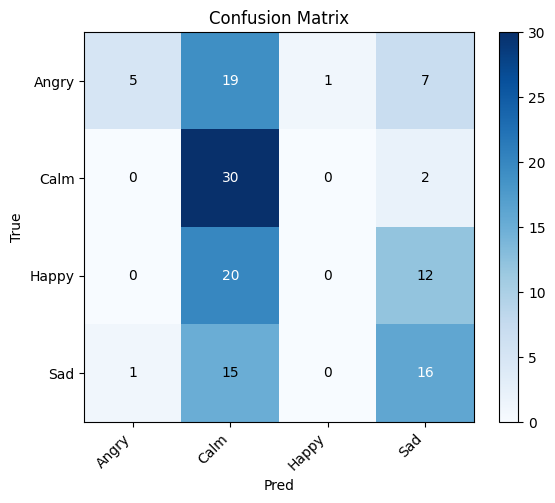

In [ ]:
# plot curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history["train_loss"], label='train'); plt.plot(history["val_loss"], label='val'); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history["train_acc"], label='train'); plt.plot(history["val_acc"], label='val'); plt.title("Accuracy"); plt.legend()
plt.show()

# load best and evaluate
checkpoint = torch.load("best_2dcnn.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state"])
_, test_acc, test_cm, test_report = eval_epoch(model, test_loader, criterion, DEVICE)
print("Test Acc:", test_acc)
print("Classification report:\n", test_report)

# confusion matrix plot
def plot_cm(cm, classes):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(classes)), yticks=np.arange(len(classes)), xticklabels=classes, yticklabels=classes, ylabel='True', xlabel='Pred', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

plot_cm(test_cm, train_dataset.classes)


In [ ]:
print(cm)

[[27  2  2  1]
 [ 1 30  0  1]
 [20  3  3  6]
 [ 7 25  0  0]]


Summary of Results with Data Augmentation (from cell UV7sG4ssdWol):

Looking at the output of the training with augmentation:

The Best Validation Accuracy achieved was 0.421875.
The final Test Accuracy was 0.421875.
Comparing this to the previous run without augmentation (cell hGtD0PpaTHiR), where the Best Validation Accuracy was 0.65625 and the final Test Accuracy was 0.65625, we see a significant decrease in performance after applying data augmentation.
Data Transformations Used (from cell d9_y-gxaaX3t):

The train_transform_aug included several transformations:

transforms.Resize(IMG_SIZE): Resizes all spectrogram images to a fixed size (150x50).
Why: Ensures all images have a consistent input size for the CNN model.
transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9,1.0)): Randomly crops a portion of the image and resizes it back to IMG_SIZE. The scale parameter limits the crop to be between 90% and 100% of the original size.
Why: Introduces variability in the position and scale of the features within the image, making the model more robust to slight shifts or variations in the spectrogram.
transforms.RandomHorizontalFlip(p=0.25): Horizontally flips the image with a probability of 0.25.
Why: This is generally used to make models invariant to horizontal reflections. However, for spectrograms, a horizontal flip reverses the time axis. This might not be acoustically meaningful or could even be detrimental depending on whether the temporal order of features is important for emotion recognition. The comment in the code careful: reverses time acknowledges this.
transforms.Grayscale(num_output_channels=1): Ensures the image is single-channel grayscale.
Why: The CNN model (CNN2D or adapted ResNet18) is designed to accept a single input channel.
transforms.ToTensor(): Converts the PIL Image or NumPy array to a PyTorch Tensor and scales the pixel values to be between 0.0 and 1.0.
Why: Necessary format for input to PyTorch models.
transforms.Lambda(lambda x: x * (0.8 + 0.4*torch.rand(1))): Applies a random gain (multiplies pixel values by a random factor between 0.8 and 1.2).
Why: Simulates variations in audio volume or recording levels, making the model more robust to amplitude differences.
transforms.Lambda(lambda x: random_time_shift(x, max_shift_fraction=0.08, p=0.7)): Randomly shifts the spectrogram horizontally (along the time axis).
Why: Makes the model more robust to slight misalignments or variations in the timing of features.
transforms.Lambda(lambda x: TimeMasking(max_mask_width=20, p=0.6)(x)): Masks out (sets to zero) random horizontal bands (time slices) in the spectrogram.
Why: Encourages the model to learn features that are not overly dependent on specific time steps, promoting robustness to missing or corrupted time segments. This is a form of SpecAugment.
transforms.Lambda(lambda x: FrequencyMasking(max_mask_height=40, p=0.6)(x)): Masks out random vertical bands (frequency bins) in the spectrogram.
Why: Encourages the model to learn features that are not overly dependent on specific frequency bins, promoting robustness to missing or corrupted frequency information. This is another form of SpecAugment.
transforms.Normalize((0.5,), (0.5,)): Normalizes the tensor with a mean of 0.5 and standard deviation of 0.5.
Why: Standard practice for neural networks to normalize input data, helping with training stability.
Why Results Went Down (Possible Reasons):

You hit on a very likely reason: the dataset is too small. The dataset has only 128 samples for training.

Here's why data augmentation might hurt performance on a small dataset:

Generating "Unrealistic" Samples: While augmentation aims to create realistic variations, with a very small base dataset, the augmented samples might not truly represent the underlying data distribution or the types of variations the model will see in real-world test data. The model might end up learning from "fake" or misleading examples.
Increased Variability on Limited Data: Augmentation significantly increases the variability in the training data. While this is good for preventing overfitting on large datasets, on a tiny dataset, introducing too much variability can make it harder for the model to find meaningful patterns in the limited number of original samples. The model might struggle to converge or learn stable representations when the training data is constantly changing drastically with each epoch.
Augmentations Not Suitable for the Task/Data: Some augmentations, like random horizontal flip (reversing time) for audio spectrograms, might actively harm performance if the temporal structure of the sound is important for distinguishing emotions.
Hyperparameters of Augmentation: The specific parameters of the augmentations (masking widths, shift amounts, probabilities) might not be optimal for this dataset and task. Aggressive augmentations can make the learning problem too difficult.
Interaction with Model Capacity: A model with high capacity (like the CNN2D or ResNet18) combined with aggressive augmentation on a small dataset can sometimes lead to the model struggling to learn anything meaningful.
In summary: While data augmentation is a powerful technique for improving generalization and combating overfitting on larger datasets, it can be counterproductive on very small datasets. The limited amount of original data might not provide a strong enough foundation for the augmented samples to be truly beneficial, and the added variability can confuse the model.

For this small dataset, simpler models (like the SVM) or less aggressive/different types of augmentation might be more effective.